In [1]:
# preparaion
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)

from prml.markov import CategoricalHMM, GaussianHMM, Kalman, Particle

本书目前为止，我们主要的注意力集中在数据集里的数据点是独立同分布的情形。这个假设使得我们将似然函数表示为在每个数据点处计算的概率分布在所有数据点上的乘积。然而，对于许多应用来说，独立同分布的假设不成立。这里，我们考虑这样的数据集中的一个重要的类型，即描述了顺序数据的数据集。这些数据集通常产生于沿着时间序列进行的测量，例如某个特定位置的连续若干天的降水量测量，或者每天汇率的值，或对于语音识别任务，在连续的时间框架下的声学特征。图13.1给出了一个涉及到语音数据的例子。

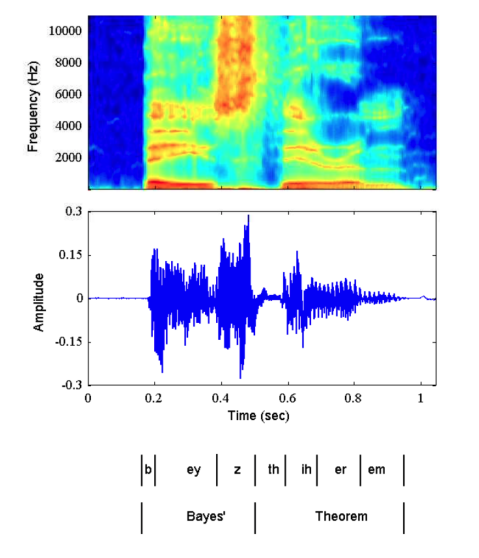

In [2]:
# 图13.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.1.png')
plt.axis('off')
ax.imshow(d)


图 13.1 单词“Bayes' theorem”的声音分析图,画出了谱系数的强度与时间的关系。

顺序数据也可以在时间序列以外的问题中出现，例如一段DNA上的碱基对序列，或者一个英语句子中的字符序列。方便起见，我们有时会用“过去”观测或者“未来”观测来称呼某个观测。然而，本章中研究的模型同样适 用于所有形式的顺序数据，而不仅仅是时间序列数据。

区分静止顺序分布和非静止顺序分布是很有用的。在静止分布中，数据会随着时间发生变化，但是生成数据的概率分布保持不变。对于更复杂的非静止分布的情形，生成概率本身会随 着时间变化。这里，我们关注的是静止分布的情形。

对于许多应用来说，例如金融预测，我们希望能够在给定时间序列中的前一个观测值的条件下，预测下一个观测值。直觉上讲，我们会猜想，与历史的观测相比，当前的观测值会为预测 未来值提供更多的信息。图13.1的例子表明，语音谱的连续观测确实具有高度的相关性。此外，考虑未来的观测对所有之前的观测的一个一般的依赖关系是不现实的，因为这样一个模型的 复杂度会随着观测数量的增加而无限制地增长。这使得我们要考虑马尔科夫模型（Markov model），其中我们假定未来的预测仅与最近的观测有关，而独立于其他所有的观测。

虽然这样的模型可以计算，但是仍然具有很严重的局限性。通过引入潜在变量，我们可以得到一个更加一般的框架，同时仍然保持计算上的可处理性，这就引出了状态空间模型（state space model）。与第9章和第12章一样，我们会看到复杂的模型可以从简单的成分中构建，特别地，从指数族分布中构建，并且可以使用概率图模型的框架进行描述。这里，我们关注状态空 间模型的两个最重要的例子，即隐马尔可夫模型（hidden Markov model），其中潜在变量是离散的，以及线性动态系统（linear dynamical system），其中潜在变量服从高斯分布。这两个模型都使用具有树结构（没有环）的有向图描述，这样就可以使用加-乘算法来高效地进行推断。





In [2]:
# load model
gaussian_hmm = GaussianHMM(
    initial_proba=np.ones(3) / 3,
    transition_proba=np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]),
    means=np.array([[0, 0], [2, 10], [10, 5]]),
    covs=np.asarray([np.eye(2) for _ in range(3)]))

In [3]:
seq = gaussian_hmm.draw(100)

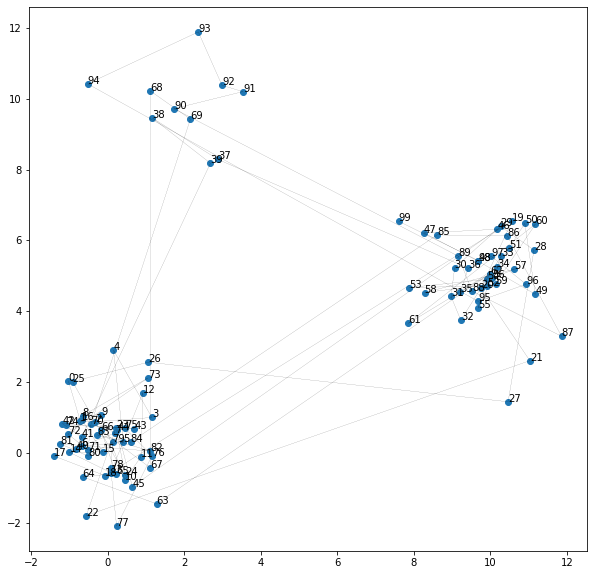

In [4]:
# plot 
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1])
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)
plt.show()

In [5]:
posterior = gaussian_hmm.fit(seq)

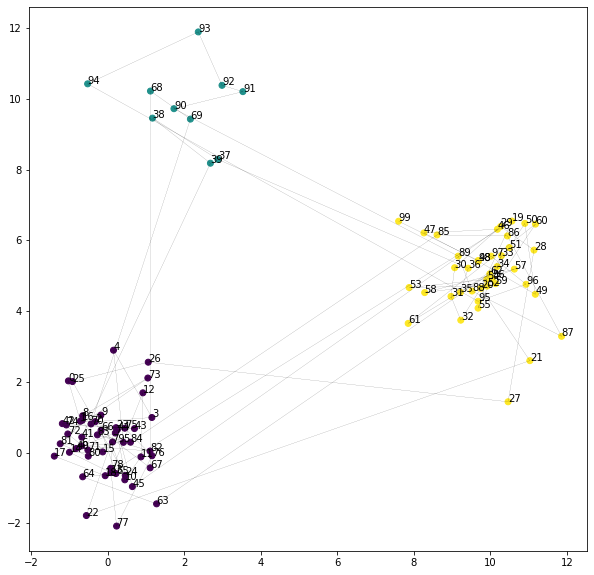

In [6]:
# plot
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1], c=np.argmax(posterior, axis=-1))
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)
plt.show()

In [7]:
# load model
categorical_hmm = CategoricalHMM(
    initial_proba=np.ones(2) / 2,
    transition_proba=np.array([[0.95, 0.05], [0.05, 0.95]]),
    means=np.array([[0.8, 0.2], [0.2, 0.8]]))

In [8]:
seq = categorical_hmm.draw(100)

In [9]:
posterior = categorical_hmm.forward_backward(seq)

In [10]:
hidden = categorical_hmm.viterbi(seq)

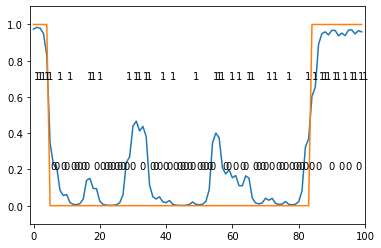

In [11]:
# plot
plt.plot(posterior[:, 1])
plt.plot(hidden)
for i in range(0, len(seq)):
    plt.annotate(str(seq[i]), (i, seq[i] / 2. + 0.2))
plt.xlim(-1, len(seq))
plt.ylim(-0.1, np.max(seq) + 0.1)
plt.show()

# 13.1 马尔可夫模型

处理顺序数据的最简单的方式是忽略顺序的性质，将观测看做独立同分布，对应于图13.2所示的图。

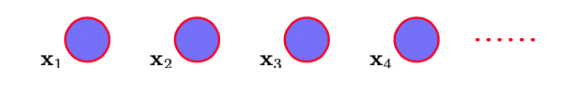

In [4]:
# 图13.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.2.png')
plt.axis('off')
ax.imshow(d)

图 13.2 对顺序观测建模的最简单的方法是将它们看做独立的，对应于没有链接的图。

然而，这种方法无法利用数据中的顺序模式，例如序列中距离较近的观测之间的相关性。例如，假设我们观测一个二值变量，这个二值变量表示某一天是否下雨。给定这个变量的一系列观测，我们希望预测下一天是否会下雨。如果我们将所有的数据都看成独立同分布的，那么我们能够从数据中得到的唯一的信息就是雨天的相对频率。然而，在实际生活中，我们知道天气经常会呈现出持续若干天的趋势。因此，观测到今天是否下雨对于预测明天是否下雨会 有极大的帮助。

为了在概率模型中表示这种效果，我们需要放松独立同分布的假设。完成这件事的一种最简单的方式是考虑马尔科夫模型（Markov model）。首先我们注意到，不失一般性，我们可以使 用概率的乘积规则来表示观测序列的联合概率分布，形式为
$ p(x_1,...,x_N) = p(x_1)\prod\limits_{n=2}^Np(x_n|x_1,...,x_{n-1}) \tag{13.1} $
如果我们现在假设右侧的每个条件概率分布只与最近的一次观测有关，而独立于其他所有之前的观测，那么我们就得到了一阶马尔科夫链（first-order Markov chain），如图13.3所示。这个模型中，$ N $次观测的序列的联合概率分布为
$ p(x_1,...,x_N) = p(x_1)\prod\limits_{n=2}^Np(x_n|x_{n-1}) \tag{13.2} $

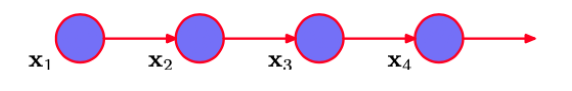

In [5]:
# 图13.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.3.png')
plt.axis('off')
ax.imshow(d)


根据d-划分的性质，给定时刻$ n $之前的所有观测，我们看到观测$ x_n $的条件概率分布为
$ p(x_n|x_1,...,x_{n-1} = p(x_n|x_{n-1}) \tag{13.3} $
从公式（13.2）开始，使用概率的乘积规则，这个等式很容易验证。因此如果我们使用这样的模型预测序列中的下一次观测，那么预测分布只依赖于最近的一次观测的值，而与所有更早的观测都无关。

在这种模型的大部分应用中，条件概率分布$ p(x_n|x_{n−1}) $被限制为相等的，对应于静止时间序列的假设。这样，这个模型被称为同质马尔科夫链（homogeneous Markov chain）。例如，如 果条件概率分布依赖于可调节的参数（参数的值可以从训练数据中确定），那么链中所有的条件概率分布会共享相同的参数值。

虽然这比独立的模型要一般一些，但是仍然非常受限。对于许多顺序的观测来说，我们预计若干个连续观测的数据的趋势会为下一次预测提供重要的信息。一种让更早的观测产生影响的方法是使用高阶的马尔科夫链。如果我们允许预测除了与当前观测有关以外，还与当前观测的 前一次观测有关，那么我们就得到了二阶马尔科夫链，如图13.4所示。

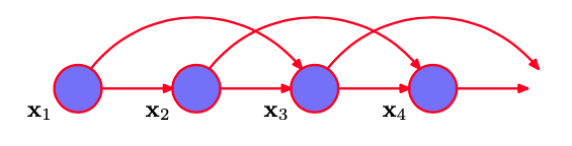

In [6]:
# 图13.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.4.png')
plt.axis('off')
ax.imshow(d)

图 13.4 一个二阶马尔科夫链，其中特定的观测$ x_n $依赖于前两次观测$ x_{n−1} $和$ x_{n−2} $的值。

现在，联合概率分布为
$ p(x_1,...,x_N) = p(x_1)p(x_2|x_1)\prod\limits_{n=3}^Np(x_n|x_{n-1},x_{n_2}) \tag{13.4} $
与之前一样，使用d-划分或者直接计算，我们看到给定$ x_{n-1} $和$ x_{n-2} $的条件下$ x_n $的条件概率分布 与所有的$ x_1,...,x_{n−3} $的观测无关。现在，每次观测由之前的两次观测所影响。我们可以类似地考虑扩展到$ M $阶马尔科夫链，其中一个特定的变量依赖于前$ M $个变量。然而，这种增长的灵活性是有代价的，因为现在模型中参数的数量要多得多。假设观测是具有$ K $个状态的离散变量，那么一阶马尔科夫链中的条件概率分布$ p(x_n|x_{n-1}) $由$ K − 1 $个参数指定，每个参数都对应于$ x_{n-1} $的$ K $个状态，因此参数的总数为$ K(K − 1) $。现在假设我们将模型推广到$ M $阶马尔科夫链，从而联合概率分布由条件概率分布$ p(x_n|x_{n−M},...,x_{n-1}) $构建。如果变量是离散变量，且条件概率分布使用一般的条件概率表的形式表示，那么这种模型中参数的数量为$ K^M (K − 1) $。 由于这个量随着$ M $指数增长，因此通常对于大的$ M $来说，使用这种方法是不实际的。

对于连续变量来说，我们可以使用线性高斯条件概率分布，其中每个结点都是一个高斯概率分布，均值是父结点的一个线性函数。这被称为自回归（autoregressive）模型或者AR模型 （Box et al.， 1994; Thiesson et al.， 2004）。另一种方法是为$ p(x_n|x_{n−M},..., x_{n-1}) $使用参数化的模型，例如神经网络。这种方法有时被称为抽头延迟线（tapped delay line），因为它对应于存储（延迟）观测变量的前面$ M $个值来预测下一个值。这样，参数的数量远远小于一个一般的模型（例如此时参数的数量可能随着$ M $线性增长），虽然这样做会使得条件概率分布被限制在一 个特定的类别中。

假设我们希望构造任意阶数的不受马尔科夫假设限制的序列模型，同时能够使用较少数量的自由参数确定。我们可以引入额外的潜在变量来使得更丰富的一类模型能够从简单的成分中构建，正如我们在第9章讨论混合概率分布和第12章讨论连续潜在变量模型时所做的那样。对于每个观测$ x_n $，我们引入一个对应的潜在变量$ z_n $（类型或维度可能与观测变量不同）。我们现在假设潜在变量构成了马尔科夫链，得到的图结构被称为状态空间模型（state space model），如图 13.5所示。它满足下面的关键的条件独立性质，即给定$ z_n $的条件下，$ z_{n−1} $和$ z_{n+1} $是独立的，从 而
$ z_{n+1} \perp z_{n-1}|z_n \tag{13.5} $
这个模型的联合概率分布为
$ p(x_1,...,x_N,z_1,...,z_N) = p(z_1)\left[\prod\limits_{n=2}^Np(z_n|z_{n-1})\right]\prod\limits_{n=1}^Np(x_n|z_n) \tag{13.6} $
使用d-划分准则，我们看到总存在一个路径通过潜在变量连接了任意两个观测变量$ x_n $和$ x_m $，且这个路径永远不会被阻隔。因此对于观测变量$ x_{n+1} $来说，给定所有之前的观测，条件概率分布$ p(x_{n+1} |x_1,...,x_n) $不会表现出任何的条件独立性，因此我们对$ x_{n+1} $的预测依赖于所有之前的观测。然而，观测变量不满足任何阶数的马尔科夫性质。我们在本章的后面几节会讨论如何计算预测分布。

对于顺序数据来说，这个图描述了两个重要的模型。如果潜在变量是离散的，那么我们得到了隐马尔科夫模型（hidden Markov model）或HMM（Elliott et al.， 1995）。注意，HMM中的观测变量可以是离散的或者是连续的，并且可以使用许多不同的条件概率分布进行建模。如果潜在变量和观测变量都是高斯变量（结点的条件概率分布对于父结点的依赖是线性高斯的形式），那么我们就得到了线性动态系统（linear dynamical system）。



# 13.2 隐马尔可夫模型

隐马尔科夫模型可以被看成图13.5所示的状态空间模型的一个具体实例，其中潜在变量是离散的。

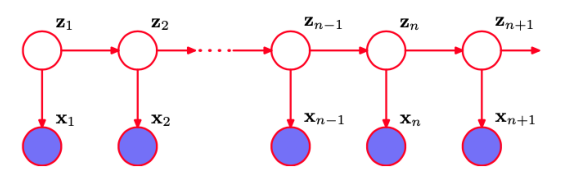

In [7]:
# 图13.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.5.png')
plt.axis('off')
ax.imshow(d)

图 13.5 我们可以使用潜在变量的马尔科夫链来表示顺序数据，每个观测都以对应的潜在变量的状态为条件。这个重要的图结构组成了隐马尔科夫模型和线性动态系统的基础。

然而，如果我们考察模型的一个单一的时间切片，那么我们看到它对应于一个混合概率 分布，对应的分量密度为$ p(x|z) $。于是，它也可以表述为混合概率模型的一个推广，其中每个观测的混合系数不是独立地选择的，而是依赖于对于前一次观测的分量的选择。HMM广泛 用于语音识别（Jelinek， 1997; Rabiner and Juang， 1993）、自然语言建模（Manning and Schütze， 1999）、在线手写识别(Nag et al.， 1986)以及生物序列（如蛋白质和DNA）的分析（Krogh et al.， 1994; Durbin et al.， 1998; Baldi and Brunak， 2001）。

与标准的混合模型的情形相同，潜在变量是离散的服从多项式分布的变量$ z_n $，描述了那个混合分量用于生成对应的观测$ x_n $。与之前一样，比较方便的做法是使用1-of-K表示方法，就像第9章那样。我们现在让$ z_n $的概率分布通过条件概率分布$ p(z_n | z_{n−1}) $对前一个潜在变量$ z_{n−1} $产生依赖。由于潜在变量是K维二值变量，因此条件概率分布对应于数字组成的表格，记作$ A $，它的元素被称为转移概率（transition prob abilities）。元素为$ A_{jk} \equiv p(z_{nk} = 1|z_{n−1}, j = 1) $。由 于它们是概率值，因此满足$ 0 \leq A_{jk} \leq 1 $且$ \sum_k A_{jk} = 1 $，从而矩阵$ A $有$ K(K − 1) $个独立的参数。这样，我们可以显式地将条件概率分布写成
$ p(z_n|z_{n-1},A) = \prod\limits_{k=1}^K\prod\limits_{j=1}^KA_{jk}^{z_{n-1, j}z_{nk}} \tag{13.7} $
初始潜在结点$ z_1 $很特别，因为它没有父结点，因此它的边缘概率分布$ p(z_1) $由一个概率向量$ \pi $表示，元素为$ \pi_k \equiv p(z_{1k} = 1) $，即
$ p(z_1 | \pi) = \prod\limits_{k=1}^K\pi_k^{z_{1k}} \tag{13.8} $
其中$ \sum_k\pi_k = 1 $。
有时可以将状态画成状态转移图中的一个结点，这样就可以图形化地表示出转移矩阵。图13.6给出了K = 3的情形。

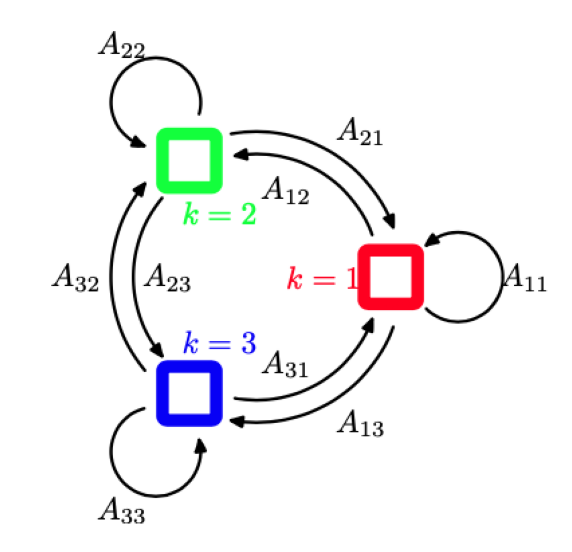

In [8]:
# 图13.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.6.png')
plt.axis('off')
ax.imshow(d)


 
图 13.6 转移图表示一个模型，它的潜在变量有三种可能的状态，对应于三个方框。黑线表示转移矩阵的元素$ A_{jk} $。

注意，这不是一个概率图模型，因为结点不是单独的变量而是一个变量的各个状态，因此我们用方框而不是圆圈来表示状态。

有时比较有用的做法是将图13.6所示的状态转移图在时间上展开。这给出了潜在变量之间转移的另一种表示方法，被称为晶格图（lattice diagram）或格子图（trellis diagram）。图13.7给出了隐马尔科夫模型的晶格图。

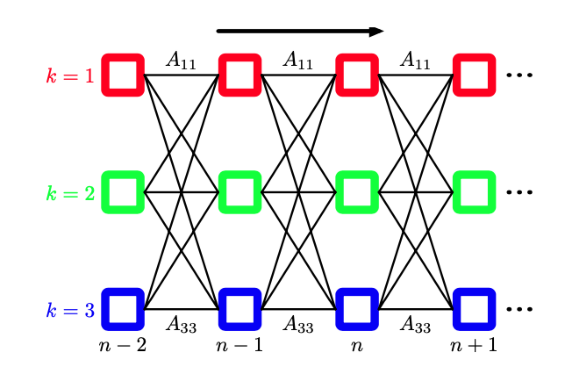

In [9]:
# 图13.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.7.png')
plt.axis('off')
ax.imshow(d)


 
图 13.7 如果我们将图13.6所示的状态转移图在时间上展开，那么我们旧得到了潜在状态的晶格图表示或格子图表示。图的每一列对应于一个潜在变量$ z_n $。

可以通过定义观测变量的条件概率分布$ p(x_n| z_n,\psi) $来确定一个概率模型，其中$ \psi $是控制概率分布的参数集合。这些条件概率被称为发射概率(emission probabilities)，可以是例如（9.11）这样的高斯分布（$ x $是连续变量），也可以是条件概率表格（$ x $是离散变量）。由于$ x_n $是观测值，因此对于一个给定的$ \psi $值，概率分布$ p(x_n|z_n,\psi) $由一个$ K $维的向量组成，对应于二值向量$ z_n $的$ K $个可能的状态。我们可以将发射概率表示为
$ p(x_n|z_n,\psi) = \prod\limits_{k=1}^Kp(x_n|\phi_k)^{z_{nk}} \tag{13.9} $
我们将注意力集中在同质的（homogeneous）模型上，其中所有控制潜在变量的条件概率分布都共享相同的参数$ A $，类似地所有发射概率分布都共享相同的参数$ \psi $（推广到更一般的情形很容易）。注意，对于一个独立同分布的数据集，一个混合模型对应于参数$ A_{jk} $对于所有的$ j $值都相同的情况，从而条件概率分布$ p(z_n|z_{n−1}) $与$ z_{n−1} $无关。这对应于将图13.5所示的图模型中的水平链接都删除。

从而观测变量和潜在变量上的联合概率分布为
$ p(X,Z|\theta) = p(z_1|\pi)\left[\prod\limits_{n=2}^N p(z_n|z_{n−1},A)\right]\prod\limits_{m=1}^Np(x_m|z_m,\phi) \tag{13.10} $
其中$ X = {x_1,...,x_N}, Z = {z_1,...,z_N} $和$ \theta = {\pi,A,\psi} $表示控制模型参数的集合。我们关于隐马尔科夫模型的大部分讨论与发射概率的特定选择无关。事实上，模型对于一大类发射概率的选择都是可以计算的，包括离散表格、高斯以及混合高斯。也可以利用判别式模型例如神经网络。这些可以用来直接对发射概率密度$ p(x|z) $建模，也可以用来给出$ p(z|x) $的一个表达式，这个表达式可以使用贝叶斯定理转化为所需的发射概率密度$ p(x|z) $（Bishop et al.，2004）。

从生成式的观点考虑隐马尔科夫模型，我们可以更好地理解隐马尔科夫模型。回忆一下，为了从一个混合高斯分布中生成样本，我们首先随机算侧一个分量，选择的概率为混合系数$ \pi_k $，然后从对应的高斯分量中生成一个样本向量$ x $。这个过程重复$ N $次，产生$ N $个独立样本组成的数据集。在隐马尔科夫模型的情形，这个步骤修改如下。首先我们选择初始的潜在变量$ z_1 $，概率由参数$ \pi_k $控制，然后采样对应的观测$ x_1 $。现在我们使用已经初始化的$ z_1 $的值，根据转移概率$ p(z_2|z_1) $来选择变量$ z_2 $的状态。从而我们以概率$ A_{jk} $选择$ z_2 $的状态$ k $，其中$ k = 1,...,K $。一旦我们知道了$ z_2 $，我们就可以对$ x_2 $采样，从而也可以对下一个潜在变量$ z_3 $采样，以此类推。这是有向图模型的祖先采样的一个例子。例如，如果我们有一个模型，其中对角转移元素$ A_{kk} $比非对角的元素大得多，那么一个典型的数据序列中，会有连续很长的一系列点由同一个概率分布生成，而从一个分量转移到另一个分量不会经常发生。图13.8说明了从隐马尔科夫模型生成样本的过程。
 

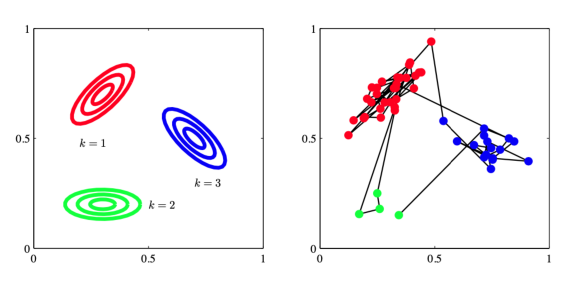

In [10]:
# 图13.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.8.png')
plt.axis('off')
ax.imshow(d)


图 13.8 从一个隐马尔科夫模型中进行采样的例子，这个模型的潜在变量z有三个状态，发射概率$ p(x|z) $是高斯概率，其中$ x $是二维的。(a)发射概率密度为常数的轮廓线，对应于潜在变量的三个状态。(b)从隐马尔科夫模型中抽取的50个样本点，数据点的颜色对应于生成它们的分量的颜色，数据点之间的连线表示连续的观测。这里，转移矩阵是固定的。在任何状态，都有5%的概率转移到每个其他的状态，有90%的概率保持相同的状态。

这个标准的HMM模型有很多变体，例如可以通过对转移矩阵$ A $的形式进行限制的方式进行限制（Rabiner， 1989）。这里我们介绍一种在实际应用中很重要的变体，被称为从左到右HMM（left-to-right HMM），它将$ A $中$ k < j $的元素$ A_{jk} $设置为0。图13.9给出了具有三个状态的这种HMM变体的状态转移图。

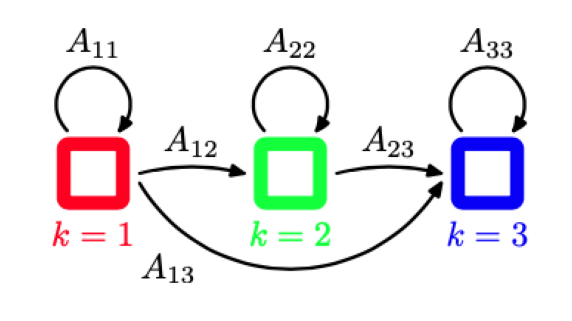

In [11]:
# 图13.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.9.png')
plt.axis('off')
ax.imshow(d)

图 13.9 三状态隐马尔科夫模型的状态转移图的例子。注意，一旦离开了某个状态，就无法再次回到这个状态。

通常对于这种模型，初始状态概率$ p(z_1) $被修改，使得$ p(z_{11}) = 1 $且$ p(z_{1j}) = 0, j \neq 1 $，也就是说，每个序列被限制为从状态$ j = 1 $开始。转移矩阵可以进一步被限制，来确保状态的下标不会发生过大的变化，即如果$ k > j + \Delta $，那么$ A_{jk} = 0 $。 图13.10给出了这种模型的晶格图。

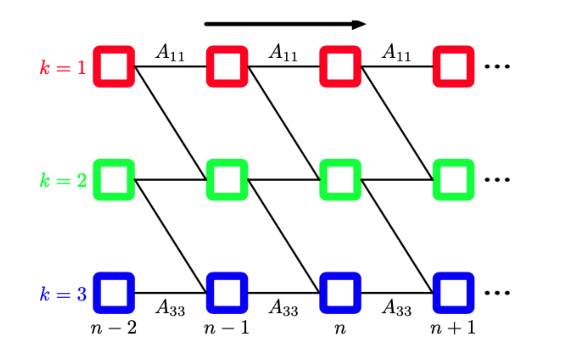

In [12]:
# 图13.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.10.png')
plt.axis('off')
ax.imshow(d)

 图 13.10 三状态从左到右HMM的晶格图，其中状态下标$ k $在每轮迭代时最多允许加1。

隐马尔科夫模型的许多应用，例如语音识别或在线字符识别都使用了这种从左到右的结构。作为从左到右隐马尔科夫模型的一个例子，我们考虑手写数字识别的一个例子。这个例子使用在线的数据，即每个手写数字由钢笔的轨迹与时间的函数表示，函数的形式是钢笔坐标的一个序列，这与附录A介绍的离线手写数字的例子不同，那个数据集由二维像素化的图像组成。图13.11给出了在线手写数字的例子。

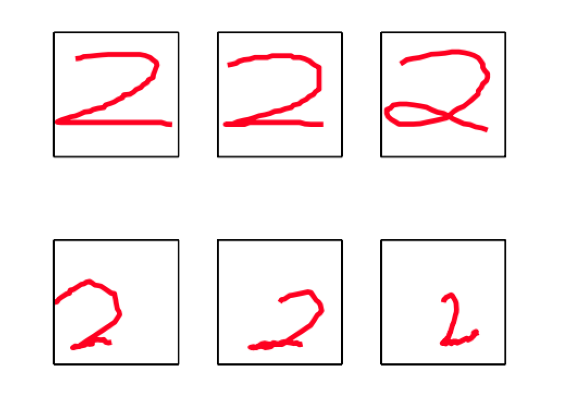

In [13]:
# 图13.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.11.png')
plt.axis('off')
ax.imshow(d)


 
图 13.11 第一行：在线手写数字的例子。第二行：生成式地采样得到的数字，模型时一个从左到右的隐马尔科夫模型，在45个手写数字组成的数据集上进行训练。

这里，我们在由45个数字“2”的例子组成的数据子集上训练一 个马尔科夫模型。有$ K = 16 $种状态，每个状态可以生成可以生成固定长度的线段，它具有16种可能的角度中的一个，因此发射概率是一个$ 16 \times 16 $的概率表，与每个状态下标的值所允许的角度值相关联。除了那些使得状态下标$ k $不变或加$ 1 $的转移概率之外，其他的转移概率全部被设置为0。模型使用了25轮的EM迭代进行最优化。通过生成式地运行这个算法，我们可以获得对模型的一些更深刻的认识，如图13.11所示。

隐马尔科夫模型的一个强大的性质是它对于时间轴上局部的变形（压缩和拉伸）具有某种程度的不变性。为了理解这一点，考虑在线手写数字例子中，数字“2”的书写方式。一个通常的手写数字由两个不同的部分组成，两个部分连接处有一个转折点。数字的第一部分从左上方开始，有一个光滑的圆弧，然后向下到转折点，或者在左下角转一个圈，接下来是第二个近似于直线的部分，扫到右下方。书写风格的自然的变化会使得这两个部分的相对大小发生变化。从生成式的观点来看，这种变化可以整合到隐马尔科夫模型中，方法是改变状态模型中保持在同一个状态的转移的数量和在连续的状态之间转移的数量。但是注意，如果数字“2”用相反的顺序书写，即从右下角开始，结束于左上角，那么即使笔迹的坐标与训练集里的一个例子完全相同，在这个模型下的观测的概率会非常小。在语音识别的问题中，对时间轴的变形与语速的自然变化相关，隐马尔科夫模型可以适应这种变形，不会对这种变形赋予过多的惩罚。



## 13.2.1 用于HMM的最大似然法

如果我们观测到一个数据集$ X = {x1,...,x_N} $，那么我们可以使用最大似然法确定HMM的参数。似然函数通过对联合概率分布(13.10)中的潜在变量进行求和的方式得到，即
$ p(X|\theta) = \sum\limits_Zp(X,Z|\theta) \tag{13.11} $
由于联合概率分布$ p(X,Z|\theta) $无法在$ n $上进行分解（与第9章关于混合概率分布的讨论不同），因此我们不能独立地在每个zn上进行求和。我们也不能显示地完成这个求和，因为有$ N $个变量需要求和，每个都有$ K $个状态，从而总计有$ K^N $个求和项。因此求和式中的项的数量随着链的长度指数增长。事实上，式（13.11）中的求和对应于在图13.7的晶格图中通过指数多条路径进行的求和。

我们之前在讨论图8.32所示的简单变量链的推断问题时，已经遇到了一个类似的困难。那里，我们能够使用图的条件独立性质对求和式重新排序，得到一个计算代价与链的长度呈线性 关系而不是指数关系的算法。我们将类似的方法应用到隐马尔可夫模型中。

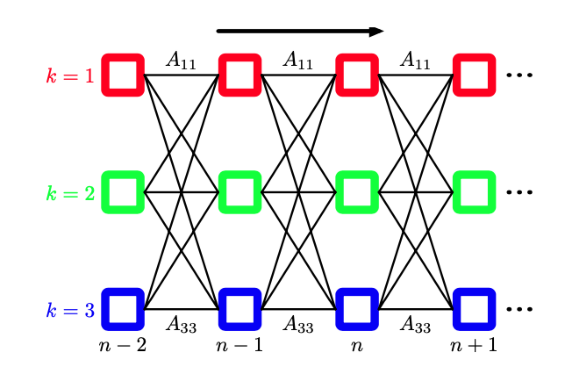

In [14]:
# 图13.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.7.png')
plt.axis('off')
ax.imshow(d)

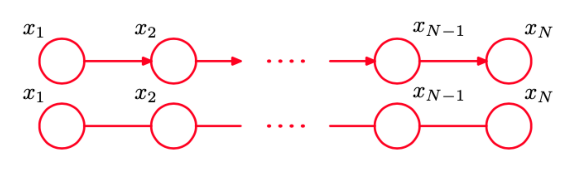

In [15]:
# 图8.32
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图8.32.png')
plt.axis('off')
ax.imshow(d)


似然函数表达式(13.11)的另一个问题是，由于它对应于混合概率分布的一个推广，因此它表示潜在变量的不同配置下，对发射概率进行求和。因此直接对这个似然函数进行最大化会导致复杂的表达式，没有解析解。这一点与简单的混合模型一样(回忆一下，独立同分布数据 的混合模型是HMM的一个具体实例)。
于是我们使用期望最大化算法来寻找对隐马尔可夫模型中似然函数进行最大化的有效框架。EM算法的开始阶段是对模型参数的某些初始的选择，我们记作$ \theta^{old} $。在E步骤中，我们使用 这些参数找到潜在变量的后验概率分布$ p(Z|X,\theta^{old}) $。然后，我们使用这个后验概率分布计算完整数据似然函数的对数的期望，得到了一个关于参数$ \theta $的函数$ Q(\theta, \theta^{old}) $，定义为
$ Q(\theta,\theta^{old}) = p(Z|X,\theta^{old})\ln p(X,Z | \theta) \tag{13.12} $
现在，引入一些记号会比较方便。我们使用$ \gamma(z_n) $来表示潜在变量$ z_n $的边缘概率分布， 用$ \xi(z_{n−1}, z_n) $表示两个连续的潜在变量的联合后验概率分布，即
$ \begin{eqnarray} \gamma(z_N) &=& p(z_n|X,\theta^{old}) \tag{13.13} \\ \xi(z_{n-1},z_n) &=& p(z_{n-1},z_n|X,\theta^{old}) \tag{13.14} \end{eqnarray} $
对于每个$ n $值，我们可以使用$ K $个非负数来存储$ \gamma(z_n) $，这些数的和等于1。类似的，我们可以使用一个由非负数组成的$ K \times K $的矩阵来存储$ \xi(z_{n−1}, z_n) $，同样加和等于1。我们也会使用$ \gamma(z_{nk}) $来表示$ z_{nk} = 1 $的条件概率，类似地使用$ \xi(z_{n−1},j,z_{nk}) $来表示后面介绍的另一个概率。 由于二值随机变量的期望就是取值为1的概率，因此得到
$ \begin{eqnarray} \gamma(z_{nk}) &=& \mathbb{E}[z_{nk}] = \sum\limits_{z_n}\gamma(z)z_{nk} \tag{13.15} \\ \xi(z_{n−1,j},z_{nk}) = \mathbb{E}[z_{n−1,j}z_{nk}] &=& \sum\limits_{z_{n-1},z_n}\xi(z_{n-1},z_n)z_{n-1,j}z_{nk} \tag{13.16} \end{eqnarray} $
如果我们将式（13.10）的联合概率分布$ p(X, Z|\theta) $代入式（13.12），使用$ \gamma $和$ \xi $的定义，我们有
$ \begin{eqnarray} Q(\theta,\theta^{old}) &=& \sum\limits_{k=1}^K\gamma(z_{1k})\ln \pi_k + \sum\limits_{n=2}^N\sum\limits_{j=1}^K\sum\limits_{k=1}^K\xi(z_{n-1,j},z_{nk})\ln A_{jk} \ & & \sum\limits_{n=1}^N\sum\limits_{k=1}^K\gamma(z_{nk})\ln p(x_n|\phi_k) \tag{13.17} \end{eqnarray} $
E步骤的目标是高效地计算$\gamma(z_n)$和$ξ(z_{n−1}， z_n)$，我们后面会详细讨论。

在M步骤中，我们关于参数$\theta = \{\pi， A， \psi\}$最大化$Q(\theta， \theta^旧)$，其中我们将$\gamma(z_n)$和$ξ(z_{n−1}， z_n)$看 做常数。关于$\pi$和$A$的最大化可以使用拉格朗日乘数法很容易求出，结果为
$ $

EM算法在初始化时必须选择$ \pi $和$ A $的初始值，这当然应该遵守概率的加和性质。注意，如果将$ \pi $或$ A $的任何元素都设为0，那么在接下来的EM更新中也会保持为0。一个典型的初始化步骤是在满足加和限制和非负限制的条件下，为这些参数随机选择初始值。注意，对于从左到右的模型的情形，我们无需对EM的结果进行特别的修改，只需在$ A_{jk} $的适当的元素设置为0即可，因为这些元素始终为0。

为了关于$ \psi_k $最大化$ Q(\theta， \theta^{old}) $，我们注意到式（13.17）中，只有最后一项依赖于$ \psi_k $，并且这一项的形式与独立同分布数据的标准混合分布的对应的函数中的数据依赖项完全相同，这一点可以通过与高斯混合模型的式（9.40）进行对比的方式看出来。这里，$ \gamma(z_{nk}) $起着“责任”的作用。如果对于不同的分量，参数$ \psi_k $独立，那么这一项可以分解为一组项的和的形式，每一项对应于一个$ k $值，每一项都可以独立地最大化。这样，我们可以简单地最大化发射概率密度$ p(x | \psi_k) $的加权的对数似然函数，权值为$ \gamma(z_{nk}) $。这里，我们假设这个最大化过程可以高效地完成。例如，在高斯发射密度的情形下，我们有$ p(x|\psi_k) = \mathcal{N}(x|\mu_k, \Sigma_k) $，最大化函数$ Q(\theta, \theta^{old}) $可得
$ \begin{eqnarray} \mu_k = \frac{\sum\limits_{n=1}^N\gamma(z_{nk})x_n}{\sum\limits_{n=1}^N\gamma(z_{nk})} \tag{13.20} \\ \Sigma_k = \frac{\sum\limits_{n=1}^N\gamma(z_{nk})(x_n - \mu_k)(x_n - \mu_k)^T}{\sum\limits_{n=1}^N\gamma(z_{nk})} \tag{13.21} \end{eqnarray} $
对于观测变量服从离散多项式分布的情形，观测变量的条件概率分布为
$ p(x|z) = \prod\limits_{i=1}^D\prod\limits_{k=1}^K\mu_{ik}^{x_ix_k} \tag{13.22} $
对应的M步骤方程为
$ \mu_{ik} = \frac{\sum\limits_{n=1}^N\gamma(z_{nk}x_{ni}}{\sum\limits_{n=1}^N}\gamma(z_{nk}) \tag{13.23} $
对于服从伯努利分布的观测变量，可以得到类似的结果。

EM算法要求有发射概率分布的参数的初始值。一种设置的方式是首先将数据集看成独立同分布的，然后通过最大似然方法调节发射概率密度，之后使用得到的值来初始化EM的参数。



## 13.2.2 前向后向算法

接下来我们寻找计算$ \gamma(z_{nk}) $和$ \xi(z_{n−1,j}, z_{nk}) $的高效的方法，对应于EM算法中的E步骤。图13.5给出的隐马尔科夫模型的图表示是一棵树，因此我们知道潜在变量的后验概率分布可以使用两阶段的信息传递算法高效地求出。在隐马尔可夫模型这一特定的问题中，这个被称为前向后向算法（forward-backward）算法（Rabiner，1989），或Baum-Welch算法（Baum，1972）。事实上，基本算法有几种变体，每个变体都可以根据沿着链传播的信息的精确形式，得到精确的边缘概率（Jordan， 2007）。我们会关注这些变体中使用最广泛的一个，被称为alpha-beta算法。

前向后向算法除了本身具有重要的实际应用价值以外，还很好地说明了之前章节中介绍的许多概念。因此我们在本节中会给出前向后向算法的一个“传统的”推导，使用概率的加法和乘积规则，并且利用由d-划分从对应的图模型中得到的条件独立性质。之后在13.2.3节，我们会看到前向后向算法如何作为8.4.4节讨论的加-乘算法的一个具体事例的方式简单地得到。

值得强调的是，潜在变量的后验概率分布的计算与发射概率密度$ p(x|z) $的形式无关，事实上与观测变量是连续的或者离散的也无关。我们所需要的全部东西是对于所有$ n $的每个$ z_n $值的概率$ p(x_n | z_n) $。并且，在本节和下一节中，我们会省略对于模型参数$ \theta^{old} $的显式依赖关系，因为模型参数始终是固定的。



首先，我们写出下面的条件独立性质(Jordan， 2007)。

$ \begin{eqnarray} p(X|z_n) &=& p(x_1,...,x_n|z_n)p(x_{n+1},...,x_N|z_n) \tag{13.24} \\ p(x_1,...,x_{n-1}|x_n,z_n) &=& p(x_1,...,x_{n-1}|z_n) \tag{13.25} \\ p(x_1,...,x_{n-1}|z_{n-1},z_n) &=& p(x_1,...,x_{n-1}|z_{n-1}) \tag{13.26} \\ p(x_{n+1},...,x_N|z_n,z_{n+1}) &=& p(x_{n+1},...,x_N|z_{n+1}) \tag{13.27} \\ p(x_{n+2},...,x_N|z_{n+1},x_{n+1}) &=& p(x_{n+2},...,x_N | z_{n+1}) \tag{13.28} \\ p(X|z_{n−1},z_n) &=& p(x_1,...,x_{n−1}|z_{n−1})p(x_n|z_n)p(x_{n+1},...,x_N|z_n) \tag{13.29} \\ p(x_{N+1}|X, z_{N+1}) &=& p(x_{N+1}|z_{N+1}) \tag{13.30} \\ p(z_{N+1}|z_N, X) = p(z_{N+1}, z_N) \tag{13.31} \end{eqnarray} $

其中$ X = {x_1,...,x_n} $。这些关系很容易使用d-划分证明。例如在第二个结果中，我们注意到结点$ x_1,...,x_{n−1} $中的任何一个结点到结点$ x_n $的路径都要通过结点$ z_n $，它被观测到。由于所有这种路径都是头到尾的，因此这个条件独立性质一定成立。作为d-划分的一个练习，读者应该花一些时间验证每一条性质。这些关系也可以使用概率的加法和乘积规则，从隐马尔科夫模型的联合概率分布中直接证明，但是麻烦得多。


首先让我们计算$ \gamma(z_{nk}) $。回忆一下，对于离散的服从多项式分布的随机变量，分量的期望值就是这个分量的值为1的概率。因此我们感兴趣的是在给定观测数据$ x_1,...,x_n $的条件下，计算$ z_n $的后验概率分布$ p(z_n |x_1,...,x_n) $。这表示一个长度为$ K $的向量，它的项对应于$ z_{nk} $的期望值。使用贝叶斯定理，我们有
$ \gamma(z_n) = p(z_n|X) = \frac{p(X|z_n)p(z_n)}{p(X)} \tag{13.32} $
注意，分母$ p(X) $隐式的以HMM的参数$ \theta^{old} $为条件，因此表示似然函数。使用条件独立性质 (13.24)，以及概率的加法和乘积规则，我们有
$ \gamma(z_n) = \frac{p(x_1,...,x_n,z_n)p(x_{n+1},...,x_N|z_n)}{p(X)} = \frac{\alpha(z_n)\beta(z_n)}{p(X)} \tag{13.33} $
其中我们定义了
$ \begin{eqnarray} \alpha(z_n) \equiv p(x_1,...,x_n,z_n) \tag{13.34} \\ \beta(z_n) \equiv p(x_{n+1},...,x_N|z_n) \tag{13.35} \end{eqnarray} $

$ \alpha(z_n) $表示观测到时刻$ n $及其之前时刻的所有数据和$ z_n $的值的联合概率，而$ \beta(z_n) $表示在给定$ z_n $的条件下，从时刻$ n + 1 $到$ N $的所有未来数据的条件概率。与之前一样，$ \alpha(z_n) $和$ \beta(z_n) $都表示$ K $个数字组成的集合，每个数字都对应于二值向量$ z_n $的“1-of-K”表示方法的一个可能的配置。我们使用$ \alpha(z_{nk}) $表示$ z_{nk} = 1 $时$ \alpha(z_n) $的值，对于$ \beta(z_{nk}) $也有类似的含义。

我们现在推导能够高效计算$ \alpha(z_n) $和$ \beta(z_n) $的递归关系。与之前一样，我们使用条件独立性质，尤其是（13.25）和（13.26），以及加和规则和乘积规则，得到用$ \alpha(z_{n−1}) $表示的$ \alpha(z_n) $，如下所述。

$ \begin{eqnarray} \alpha(z_n) &=& p(x_1,...,x_n,z_n) \\ &=& p(x_1,...,x_n|z_n)p(z_n) \\ &=& p(x_n|z_n)p(x_1,...,x_{n-1}|z_n)p(z_n) \\ &=& p(x_n|z_n)p(x_1,...,x_{n-1},z_n) \\ &=& p(x_n|z_n)\sum\limits_{z_{n-1}}p(x_1,...,x_{n-1},z_{n-1},z_n) \\ &=& p(x_n|z_n)\sum\limits_{z_{n-1}}p(x_1,...,x_{n-1},z_n|z_{n-1})p(z_{n-1}) \\ &=& p(x_n|z_n)\sum\limits_{z_{n-1}}p(x_1,...,x_{n-1}|z_{n-1})p(z_n|z_{n-1})p(z_{n-1}) \\ &=& p(x_n|z_n)\sum\limits_{z_{n-1}}p(x_1,...,x_{n-1},z_{n-1})p(z_n|z_{n-1}) \end{eqnarray} $

使用式（13.34）给出的$ \alpha(z_n) $的定义，得到
$ \alpha(z_n) = p(x_n|z_n)\sum\limits_{z_{n-1}}\alpha(z_{n-1})p(z_n|z_{n-1}) \tag{13.36} $
值得花时间仔细研究一下这个递归的关系。注意，求和式中有$ K $项，右侧必须对$ z_n $的$ K $个值中的每一个进行计算，因此$ \alpha $递归的每一步的计算代价为$ O(K^2) $。图13.12用晶格图说明了$ \alpha(z_n) $的递归方程。
 

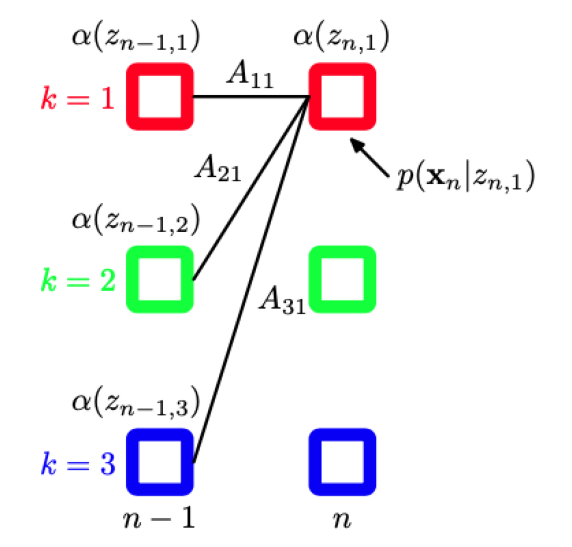

In [16]:
# 图13.12
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.12.png')
plt.axis('off')
ax.imshow(d)


图 13.12 计算$ \beta $变量的后向递归方程（13.38）的说明。在这个晶格图片段中，我们看到$ \beta(z_n,1) $的计算方式是将$ n + 1 $步的$ \beta(z_{n+1}) $的元素$ \beta(z_{n+1},k) $加权求和，权值为$ A_{ik} $（对应于$ p(z_{n+1}|z_n) $）与发射概率密度$ p(x_n|z_{n+1},k) $的对应值的乘积。

为了开始这个递归过程，我们需要一个初始条件，形式为
$ \alpha(z_1) = p(x_1,z_1) = p(z_1)p(x_1|z_1) = \prod\limits_{k=1}^K{\pi_kp(x_1|\phi_k)}^{z_{1k}} \tag{13.37} $
这表明对于$ k = 1,...,K $，$ \alpha(z_{1k}) $的值为$ \pi_kp(x_1 | \psi_k) $。从链的第一个结点开始，我们可以沿着链计算每个潜在结点的$ \alpha(z_n) $。由于递归的每一步涉及到与一个$ K \times K $的矩阵相乘，因此计算整个链的这些量的整体代价是$ O(K^2N) $。
类似地我们可以使用条件独立性质（13.27）和（13.28）得到$ \beta(z_n) $的递归关系，即
$ \begin{eqnarray} \beta{z_n} &=& p(x_{n+1},...,x_N|z_n) \ &=& \sum\limits_{z_{n+1}}p(x_{n+1},...,x_N,z_{n+1}|z_n) \ &=& \sum\limits_{z_{n+1}}p(x_{n+1},...,x_N|z_n,z_{n+1})p(z_{n+1}|z_n) \ &=& \sum\limits_{z_{n+1}}p(x_{n+1},...,x_N|z_{n+1})p(z_{n+1}|z_n) \ &=& \sum\limits_{z_{n+1}}p(x_{n+1},...,x_N|z_{n+1})p(z_{n+1}|z_{n+1})p(z_{n+1}|z_n) \ \end{eqnarray} $
使用公式（13.35）给出的$ \beta(z_n) $的定义，得到
$ \beta(z_n) = \beta(z_{n+1})p(x_{n+1}|z_{n+1})p(z_{n+1}|z_n) \tag{13.38} $
注意，在这种情况下，我们得到了一个后向信息传递算法，它根据$ \beta(z_{n+1}) $计算$ \beta(z_n) $。在每一步中，我们通过发射概率$ p(x_{n+1}|z_{n+1}) $将观测$ x_{n+1} $的效果吸收进来，然后对$ z_{n+1} $求和。图13.13说明了这个过程。
 

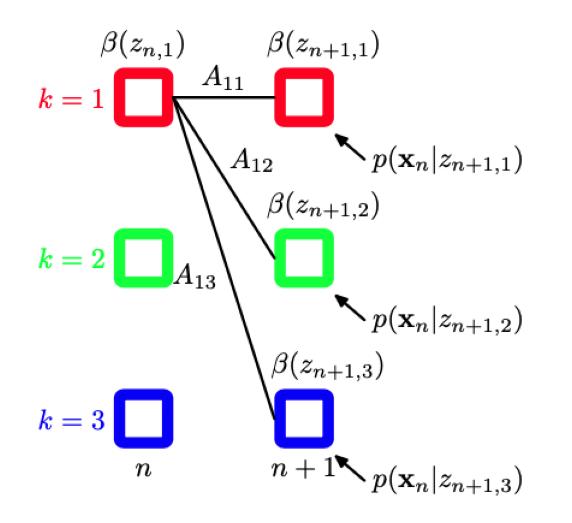

In [17]:
# 图13.13
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.13.png')
plt.axis('off')
ax.imshow(d)


图 13.13 计算$ \beta $变量的后向递归方程（13.38）的说明。在这个晶格图片段中，我们看到$ \beta(z_n,1) $的计算方式是将$ n + 1 $步的$ \beta(z_{n+1}) $的元素$ \beta(z_{n+1},k) $加权求和，权值为$ A_{ik} $（对应于$ p(z_{n+1}|z_n) $)与发射概率密度$ p(x_n|z_{n+1},k) $的对应值的乘积。

与之前一样，我们需要一个递归的起始条件，即$ \beta(z_n) $的一个值。可以这样获得：令式（13.33）中的$ n = N $，然后使用定义（13.34）代替$ \alpha(z_n) $，可得
$ p(z_N|X) = \frac{p(X,z_N)\beta(z_N)}{p(X)} \tag{13.39} $
只要我们对于所有的$ z_n $都有$ \beta(z_n ) = 1 $，这个结果就是正确的。
在M步方程中，$ p(X) $可以消去。例如，（13.20）给出$ \mu_k $的M步骤方程的形式为
$ \mu_k = \frac{\sum\limits_{n=1}^n\gamma(z_{nk})x_n}{\sum\limits_{n=1}^n\gamma(z_{nk})} = \frac{\sum\limits_{n=1}^n\alpha(z_{nk})\beta(z_{nk})x_n}{\sum\limits_{n=1}^n\alpha(z_{nk})\beta(z_{nk})} \tag{13.40} $
然而，$ p(X) $表示似然函数，我们通常在EM优化过程中能够监视它的值，因此能够计算出这个值是很有用的。如果我们将(13.33)的两侧对$ z_n $求和，使用左侧是一个归一化分布的事实，我们有
$ p(X) = \sum\limits_{z_n}\alpha(z_n)\beta(z_n) \tag{13.41} $
因此我们可以任意选择方便的$ n $，通过计算这个求和式计算似然函数。例如，如果我们只希望计算似然函数，那么我们可以从链的起点到终点运行$ \alpha $的递归过程，然后使用$ n = N $的结果，利用$ \beta(z_n ) $是一个元素全部为$ 1 $的向量这一事实。在这种情况下，$ \beta $递归不再需要，从而我们有
$ p(X) = \sum\limits_{z_N}\alpha(z_N) \tag{13.42} $
让我们花一些时间考察$ p(X) $的这个结果的意义。回忆一下，为了计算似然函数，我们应该 在Z的所有可能值上对联合概率分布$ p(X, Z) $求和。每个这样的值表示每个时间步骤下对隐含状态的一个特定的选择，换句话说，求和式中的每一项都是晶格图中的一个路径，并且回忆一 下，这种路径有指数多条。通过将似然函数表示为（13.42）的形式，我们将计算代价从关于链长度的指数量级减小到了线性量级，方法是交换了加和与乘积的顺序，从而在每个时间步骤$ n $中，我们对通过每个状态$ z_{nk} $的所有路径的贡献进行求和，得到了中间的量$ \alpha(z_n) $。




接下来我们考虑$ \xi(z_{n−1}, z_n) $的计算，它对应于$ (z_{n−1}, z_n) $的$ K \times K $个配置下的每一个配置的条件概率$ p(z_{n−1}, z_n|X) $的值。使用$ \xi(z_{n−1}, z_n) $的定义，应用贝叶斯定理，我们有
$ \begin{eqnarray} \xi(z_{n-1},z_n) &=& p(z_{n-1},z_n|X) \ &=& \frac{p(X|z_{n-1},z_n)p(z_{n-1},z_n)}{p(X)} \ &=& \frac{p(x_1,...,x_{n−1}|z_{n−1})p(x_n|z_n)p(x_{n+1},...,x_N|z_n)p(z_n|z_{n−1})p(z_{n−1})}{p(X)} \ &=& \frac{\alpha(z_{n−1})p(x_n|z_n)p(z_n|z_{n−1})\beta(z_n)}{p(X)} \tag{13.43} \end{eqnarray} $
其中我们已经使用了条件独立性质（13.29）以及式（13.34）和（13.35）给出的$ \alpha(z_n) $和$ \beta(z_n) $的定义。因此我们可以使用$ \alpha $和$ \beta $的递归结果直接计算$ \xi(z_n−1, z_n) $。

让我们总结一下使用EM算法训练隐马尔科夫模型所需的步骤。首先，我们需要进行对参数$ \theta^{old} $进行一个初始的选择，其中$ \theta \equiv (\pi, A, \psi) $。参数$ A $和$ \pi $要么均匀的初始化，要么从一个均匀分布中随机初始化（满足非负限制与加和限制）。参数$ \psi $的初始化依赖于概率分布的形式。对于高斯分布的情形，参数$ \mu_k $可以通过对数据使用K均值算法进行初始化，$ \Sigma_k $可以使用对应的K均值聚类的协方差矩阵初始化。然后我们运行前向$ \alpha $递归过程和后向$ \beta $递归过程，使用这些结果计算$ \gamma(z_n) $和$ \xi(z_{n−1}, z_n) $。在这个阶段，我们也可以计算似然函数。这完成了E步骤，然后我们使用这个结果，使用13.2.1节的M步骤方程找到一个修正参数$ \theta^{new} $。然后我们继续交替进行E步骤和M步骤，直到满足某些收敛准则，例如似然函数的变化低于某个阈值。

注意，在这些递归关系中，观测只出现在条件概率分布$ p(x_n | z_n) $中。因此，递归过程与观测变量的种类和维度无关，也于这个条件概率的形式无关，只要对于$ z_n $的$ K $种可能状态的每一个，这个概率的值可以计算即可。

在之前的章节中，我们已经看到，当数据点的数量相对于参数的数量来说较大的时候，最大似然方法最有效。这里，我们注意到，使用最大似然方法，隐马尔可夫模型可以高效地训练，只要训练的序列足够长。我们还可以使用多个较短的序列，这需要对隐马尔可夫模型EM算法进行一些简单的修改。在从左到右模型的情况下，这特别重要，因为在一个给定的观测序列中， 对应于A的非对角元素的给定的状态转移最多出现一次。

我们感兴趣的另一个量是预测分布，其中观测数据是$ X = {x_1,...,x_n} $，我们希望预测$ x_{n+1} $，这对于诸如金融预测这种实时的应用来说很重要。与之前一样，我们使用加法和乘积规则以及条件独立性质（13.30）和（13.31），可得
$ \begin{eqnarray} p(x_{N+1}|X) &=& \sum\limits_{z_{N+1}}p(x_{N+1},z_{N+1}|X) \\ &=& \sum\limits_{z_{N+1}}p(x_{N+1}|z_{N+1})p(z_{N+1}|X) \\ &=& \sum\limits_{z_{N+1}}p(x_{N+1}|z_{N+1})\sum\limits_{z_N}p(x_{N+1},z_N|X) \\ &=& \sum\limits_{z_{N+1}}p(x_{N+1}|z_{N+1})\sum\limits_{z_N}p(x_{N+1}|z_N)p(z_N|X) \\ &=& \sum\limits_{z_{N+1}}p(x_{N+1}|z_{N+1})\sum\limits_{z_N}p(x_{N+1}|z_N)\frac{p(z_N,X)}{p(X)} \\ &=& \frac{1}{p(X)}\sum\limits_{z_{N+1}}p(x_{N+1}|z_{N+1})\sum\limits_{z_N}p(x_{N+1}|z_N)\alpha(z_N) \tag{13.44} \end{eqnarray} $
这可以通过首先运行前向$ \alpha $递归然后计算最后一个式子中关于$ z_n $和$ z_{n+1} $的求和式的方式得到。第一项关于$ z_n $的求和式可以被存储起来，一旦$ x_{n+1} $被观测到，就可以用来运行$ \alpha $递归的前向步骤，进行到下一步，来预测接下来的值$ x_{n+2} $。注意，在（13.44）中，从$ x_1 $和$ x_n $的所有数据的影响被聚集到了$ \alpha(z_n) $的$ K $个值当中。因此预测分布可以使用固定量的存储空间向前推进无穷多次，这正是实时应用所要求的。

这里，我们已经讨论了使用最大似然方法估计HMM的参数。这个框架很容易推广到正则化的最大似然函数，方法是引入模型参数$ \pi, A $和$ \psi $上的先验概率分布，然后通过最大化后验概率的方式估计参数的值。这个也可以使用EM算法计算，其中E步骤与上面的讨论相同，M步骤在最大化之前给似然函数$ Q(\theta, \theta^{old}) $加上先验概率分布$ p(\theta) $的对数，可以直接应用本书讨论的多种方法进行求解。此外，我们可以使用变分方法，得到HMM的一个纯粹的贝叶斯方法，其中我们对参数概率分布进行积分或求和（MacKay， 1997）。与最大似然方法相同，这产生了一个两遍的前向后向递归的过程来计算后验概率分布。



## 13.2.3 用于HMM的加和-乘积算法

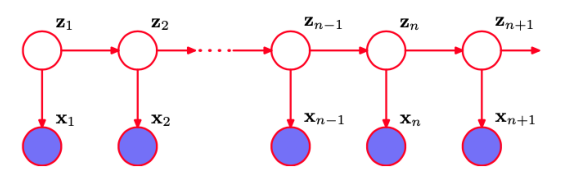

In [18]:
# 图13.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.5.png')
plt.axis('off')
ax.imshow(d)

图13.5给出的表示隐马尔可夫模型的有向图是一棵树，因此我们可以使用加-乘算法来求解寻找局部边缘概率的问题。毫不令人惊讶的事实是，这等价于前一节讨论的前向-后向算法，因此加-乘算法给我们提供了一种简单的方式推导alpha-beta递归公式。

首先，我们将图13.5所示的有向图变换为因子图，图13.14给出了一个代表性的片段。

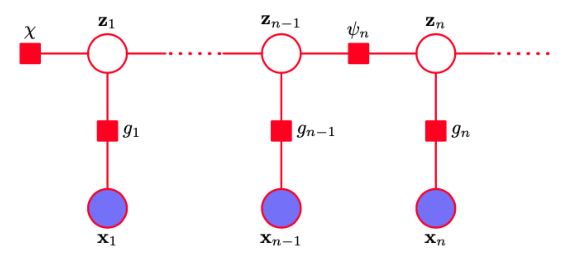

In [19]:
# 图13.14
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.14.png')
plt.axis('off')
ax.imshow(d)

图 13.14 隐马尔可夫模型的因子图表示的一个片段。

这种形式的因子图显式地画出了潜在结点和观测结点。然而，对于解决推断问题来说，我们总是以变量$ x_1,...,x_N $为条件，因此我们可以通过将发射概率整合到转移概率因子中的方式来简化因子图。

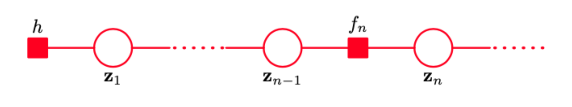

In [20]:
# 图13.15
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.15.png')
plt.axis('off')
ax.imshow(d)

图 13.15 一个简化形式的因子图用来描述隐马尔可夫模型。

这就产生了图13.15给出的简化的因子图表示，其中因子为
$ \begin{eqnarray} h(z_1) &=& p(z_1)p(x_1|z_1) \tag{13.45} \\ f_n(z_{n-1},z_n) &=& p(z_n|z_{n-1})p(x_n|z_n) \tag{13.46} \end{eqnarray} $
为了推导alpha-beta算法，我们将最后的隐含变量$ z_N $看成根结点，首先从叶结点$ h $向根结点传递信息。根据式（8.66）和（8.69）给出的信息传播的一般结果，我们看到在隐马尔可夫模型中传递的信息的形式为
$ \begin{eqnarray} \mu_{z_{n-1} \to f_n}(z_{n-1}) &=& \mu_{f_{n-1} \to z_{n-1}}(z_{n-1}) \tag{13.47} \\ \mu_{f_n \to z_n}(z_n) &=& \sum\limits_{z_{n-1}}f_n(z_{n-1},z_n)\mu_{z_{n-1} \to f_n}(z_{n-1}) \tag{13.48} \end{eqnarray} $
这些方程表示沿着链的信息前向传递，等价于前一节推导出的alpha递归，说明如下。注意，由于变量结点$ z_n $只有两个相邻结点，因此它们不进行计算。

我们可以使用式（13.47）从式（13.48）中消去$ \mu_{z_{n−1} \to f_n}(z_{n−1}) $，得到$ f \to z $的信息的递归方程，形式为
$ \mu_{f_n \to z_n}(z_n) = \sum\limits_{z_{n-1}}f_n(z_{n-1},z_n)\mu_{z_{n-1} \to f_n}(z_{n-1}) \tag{13.49} $
如果我们回忆一下定义（13.46），并且如果我们定义
$ \alpha(z_n) = \mu_{f_n \to z_n}(z_n) \tag{13.50} $
那么我们就得到了式（13.36）给出的alpha递归方程。我们还需要验证$ \alpha(z_n) $本身等价于之前的定义。可以这样做：使用初始条件（8.71），然后注意到$ \alpha(z_1) $为$ h(z_1) = p(z_1)p(x_1|z_1) $，这与式（13.37）完全相同。由于初始的$ \alpha $是相同的，并且它们使用同样的方程进行迭代地计算，因此所有后续的$ \alpha $一定相同。

接下来我们研究从根结点传递回到叶结点的信息，形式为
$ \mu_{f_{n+1} \to z_n}(z_n) = \sum\limits_{z_{n+1}}f_{n+1}(z_n,z_{n+1})\mu_{f_{n+2} \to z_{n+1}}(z_{n+1}) \tag{13.51} $
其中，同样的，我们消去了形如$ z \to f $的信息，因为变量结点不参与计算。使用定义（13.46）消去$ f_{n+1}(z_n, z_{n+1}) $，然后定义
$ \beta{z_n} = \mu_{f_{n+1} \to z_n}(z_n) \tag{13.52} $
我们就得到了式（13.38）定义的beta递归方程。我们同样可以验证beta变量本身是等价的。我们注意到式（8.70）表明根变量结点发送的初始结点为$ \mu_{z_N \to f_N}(z_N) = 1 $，这与13.2.2节给出了对$ \beta(z_N) $的初始化完全相同。

加-乘算法也指定了如何计算边缘概率，一旦所有的信息都已经被计算出来。特别的，式（8.63）给出的结果表明结点$ z_n $处的局部边缘概率是输入信息的乘积。由于我们以变量$ X = {x_1,...,x_N} $为条件，因此我们计算的是联合概率分布
$ p(z_n,X) = \mu_{f_n \to z_n}(z_n)\mu_{f_{n+1} \to z_N}(z_n) = \alpha(z_n)\beta(z_n) \tag{13.53} $
两边同时除以$ p(X) $，得到
$ \gamma(z_n) = \frac{p(z_n,X)}{p(X)} = \frac{\alpha(z_n)\beta(z_n)}{p(X)} \tag{13.54} $
这与式（13.33）相符。式（13.43）给出的结果可以类似的从式（8.72）中推导出。



## 13.2.4 缩放因子

在我们能够在实际应用中使用前向后向算法之前，有一件事情必须强调。根据递归关系（13.36），我们注意到在每一步中，新的值$ \alpha(z_n) $为前一个值$ \alpha(z_{n−1}) $乘以$ p(z_n| z_{n−1}) $和$ p(x_n|z_n) $。由于这些概率通常远远小于1，因此随着我们沿着链向前推进，$ \alpha(z_n) $很快就会指数地趋近于零。对于中等的链长度（例如100左右），$ \alpha(z_n) $的计算很快就会超出计算机的计算范围，即使使用双精度浮点数也是如此。

在独立同分布数据的情形，我们使用取对数的方式，隐式地避开了计算似然函数的这个问题。不幸的是，这种方法在这里没有作用，因为我们对很小的数字的乘积进行求和（事实上我们隐式地对图13.7的晶格图中的所有可能的路径求和）。因此我们使用重新缩放的$ \alpha(z_n) $和$ \beta(z_n) $来计算，它们的值保持与单位长度在同一个量级上。正如我们将看到的那样，当我们在EM算法中使用这些缩放的量时，对应的缩放因子会消去。

在式（13.34）中，我们定义了$ \alpha(z_n) = p(x_1,...,x_n,z_n) $，表示所有截止到$ x_n $的观测以及潜在变量$ z_n $的联合概率分布。现在我们定义$ \alpha $的一个标准化的版本，形式为

$ \hat{\alpha}(z_n) = p(z_n|x_1,...,x_n) = \frac{\alpha(z_n)} {p(x_1,...,x_n)} \tag{13.55} $

我们预计这个量在数值计算上可以表现良好，因为对任意$ n $值，它都是$ K $个变量上的一个概率分布。为了将缩放的alpha变量与原始的alpha变量关联起来，我们引入缩放因子，它由观测变量上的条件概率分布定义，即
$ c_n = p(x_n|x_1,...,x_{n-1}) \tag{13.56} $
根据乘积规则，我们有
$ p(x_1,...,x_n) = \prod\limits_{m=1}^n c_m \tag{13.57} $
因此
$ \alpha(z_n) = p(z_n|x_1,...,x_n)p(x_1,...,x_n) = \left(\prod\limits_{m=1}^nc_m\right)\hat{\alpha}(z_n) \tag{13.58} $
然后我们可以将$ \alpha $的递归方程（13.36）转化为$ \hat{\alpha} $的递归方程，形式为
$ c_n\hat{\alpha}(z_n) = p(x_n|z_n)\sum\limits_{z_{n-1}}\hat{\alpha}(z_{n-1})p(z_n|z_{n-1}) \tag{13.59} $
注意，在用于计算$ \hat{\alpha}(z_n) $的前向信息传播阶段的每一步，我们必须计算和存储$ c_n $，这很容易做到，因为它是将式（13.59）的右手边标准化得到$ \hat{\alpha}(z_n) $的标准化系数。

类似的，我们可以使用下式
$ \beta(z_n) = \left(\prod\limits_{m=n+1}^Nc_m\right)\hat{\beta}(z_n) \tag{13.60} $
定义重新缩放的变量$ \beta(z_n) $。它的值再次保持在机器的精度范围内，因为根据式（13.35），$ \hat{\beta}(z_n) $仅仅是两个条件概率分布的比值
$ \hat{\beta}(z_n) = \frac{p(x_{n+1},...,x_N|z_n)}{p(x_{n+1},...,x_N|x_1,...,x_n)} \tag{13.61} $

这样，根据$ \beta $的递归结果（13.38）可以得到下面的对重新标准的变量的递归方程
$ c_{n+1}\hat{\beta}(z_n) = \sum\limits_{z_{n+1}}\hat{\beta}(z_{n+1})p(x_{n+1}|z_{n+1})p(z_{n+1}|z_n) \tag{13.62} $
在应用这个递归关系时，我们使用之前在$ \alpha $阶段计算的缩放因子$ c_n $。
根据式（13.57），我们看到似然函数可以使用下式求出
$ p(X) = \prod\limits_{n=1}^Nc_n \tag{13.63} $
类似地，使用（13.33）和（13.43）以及（13.63），我们看到所求的边缘概率为
$ \begin{eqnarray} \gamma(z_n) &=& \hat{\alpha}(z_n)\hat{\beta}(z_n) \tag{13.64} \\ \xi(z_{n-1},z_n) &=& c_n^{-1}\hat{\alpha}(z_{n-1})p(x_n|z_n)p(z_n|z_{n-1})\hat{\beta}(z_n) \tag{13.65} \end{eqnarray} $
最后，我们注意到前向后向算法有另一种公式（Jordan，2007），其中后向传递由基于$ \gamma(z) = \hat{\alpha}(z_n)\hat{\beta}(z_n) $的递归定义，而不是使用$ \hat{\beta}(z_n) $。这个$ \alpha − \gamma $递归要求前向传递过程首先完成，从而在后向传递过程中能得到所有的$ \hat{\alpha}(z_n) $，而$ \alpha − \beta $算法的前向和向后传播可以独立地进行。虽然这两个算法的计算代价是可比的，但是在隐马尔可夫模型的情形下，$ \alpha − \beta $版本是最经常遇到的，而对于线性动态系统，$ \alpha − \gamma $形式类似的递归规程更常见。



## 13.2.5 维特比算法

在隐马尔可夫模型的许多应用中，潜在变量有许多有意义的直观意义，因此对于给定的观测序列，我们常常感兴趣的是寻找概率最高的隐含状态序列。例如，在语音识别中，对于一个给定的声音观测序列，我们可能希望找到概率最大的音素序列。由于隐马尔可夫模型的图是一棵有向树，因此这个问题可以使用最大家和算法精确地求解。回忆一下，根据8.4.5节，寻找潜在变量的概率最高的序列与寻找分别概率最高的状态的集合是不相同的。后一个问题可以这样解决：首先运行前向后向算法（加-乘算法）找到潜在变量边缘概率\gamma（z_n），然后单独最大化 每个概率（Duda et al.， 2001）。然而，通常这样的状态集合不会对应于最可能的状态序列。事实上，如果对于两个连续的状态，它们单独的概率都是最高的，但是连接它们的转移矩阵的元素为0，那么这个状态集合表示一个具有零概率的序列。

在实际应用中，我们通常感兴趣的是寻找最可能的状态序列（sequence），这可以使用最大加和算法高效地求出，这个算法在隐马尔科夫模型中被称为维特比算法（Viterbi algorithm）（Viterbi， 1967）。注意，最大加和算法作用于对数概率，因此无需使用前向后向算法中的重新缩放的变量。图13.16给出了隐马尔科夫模型的晶格图的一个片段。

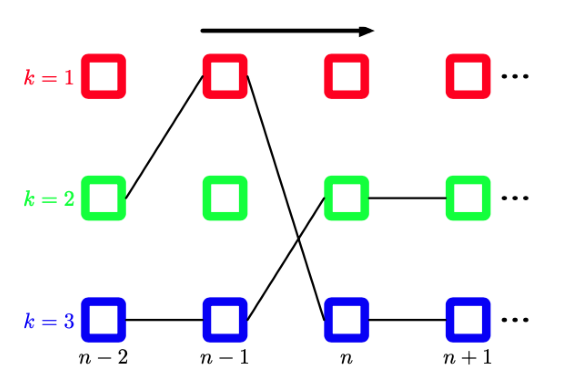

In [21]:
# 图13.16
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.16.png')
plt.axis('off')
ax.imshow(d)

图 13.16 HMM晶格图片段，画出了两条可能的路径。维特比算法从指数多种可能的路径中高效地确定概率最高的路径。对于任意给定的路径，对应的概率为转移矩阵的元素$ A_{jk} $（对应于每个路径片段的概率$ p(z_{n+1}|z_n) $）和与路径上的每个结点相关联的发射概率密度$ p(x_n|k) $的乘积。

正如我们已经注意到的，通过经过的可能的路径的数量随着链的长度指数增长。维特比算法高效地搜索这个路径空间，找 到概率最高的路径，计算代价仅仅随着链的长度线性增长。 与加-乘算法相同，我们首先将隐马尔可夫模型表示为因子图，如图13.15所示。同样的，我们将变量结点$ z_n $当成根结点，从根结点开始向叶结点传递信息。使用公式（8.93）和（8.94）的结果，我们看到在最大加和算法中传递的信息为
$ \begin{eqnarray} \mu_{z_n \to f_{n+1}}(z_n) &=& \mu_{f_n \to z_n}(z_n) \tag{13.66} \\ \mu_{f_{n+1} \to z_{n+1}} &=& \max_{z_n}{\ln f_{n+1}(z_n,z_{n+1}) + \mu_{z_n \to f_{n+1}}(z_n)} \tag{13.67} \end{eqnarray} $
如果消去两个方程间的$ \mu_{z_n \to f_{n+1}}(z_n) $，然后使用式（13.46），我们得到了$ f \to z $的信息的递归方程，形式为
$ \omega(z_{n+1}) = \ln p(x_{n+1}|z_{n+1}) + \max_{z_n}{\ln p(z_{n+1}|z_n) + \omega(z_n)} \tag{13.68} $
其中我们引入了记号$ \omega(z_n) \equiv \mu_{f_n \to z_n}(z_n) $。
根据公式（8.95）和（8.96），这些信息使用下面的公式初始化
$ \omega(z_1) = \ln p(z_1) + \ln p(x_1|z_1) \tag{13.69} $
其中我们已经使用了式（13.45）。注意，为了保持记号简洁，我们略去了对模型参数$ \theta $的依赖关系，它在我们寻找概率最高的序列的过程中保持固定。

Viterbi算法也可以直接从联合概率分布的定义（13.6）中直接推导，方法是取对数，然后交换求最大值和求和的顺序。很容易看到$ \omega(z_n) $具有下面的概率意义
$ \omega(z_n) = \max_{z_1,...,z_{n-1}} \ln p(x_1,...,x_n,z_1,...,z_n)\tag{13.70} $

一旦我们完成了在$ z_n $上的最大化过程，那么我们就得到了对应于概率最大的路径的联合概率分布$ p(X, Z) $。我们还希望找到对应于这条路径的潜在变量值的序列。为了完成这一点，我们简单地使用8.4.5节讨论的反向跟踪方法。具体来说，我们注意到在$ z_n $上的最大化过程必须在$ z_{n+1} $的$ K $个可能值的每一个值上进行。假设对于$ z_{n+1} $的$ K $个值中的每一个值，我们都记录下与最大值相对应的$ z_n $的值。让我们将这个函数记作$ \psi(k_n) $，其中$ k \in {1,...,K} $。一旦我们将信息传递到了链的末端，找到了概率最大的状态$ z_n $，那么我们可以使用这个函数来沿着链进行反向跟踪，方法是递归地应用下式
$ k_{n-1}^{max} = \psi(k_n^{max}) \tag{13.71} $

直观上讲，我们可以按照下面的方式理解维特比算法。朴素地说，我们可以显式地考虑通过晶格的指数多条路径，计算每条路径的概率，然后选择具有最高概率的路径。然而，我们注意到，我们可以对计算量进行极大的简化。假设对于每条路径，我们在沿着通过晶格的每条路径前向计算时，通过将转移概率与发射概率的乘积进行求和的方式求出这个概率。考虑一个特定的时刻$ n $以及在那个时刻的一个特定的状态$ k $。会存在许多条路径收敛到晶格图中的对应的结点。然而，我们只需要保留当前具有最高概率的特定的路径即可。由于在时刻$ n $有$ K $个状态，因此我们需要跟踪$ K $个这样的路径。在时刻$ n + 1 $，会存在$ K $个可能的路径要考虑，由在$ K $个当前状态中的每个状态引出的$ K $个可能的路径组成，但是在$ n + 1 $时刻，我们还是只需保留对应于最优路径的K个状态。当我们到达最后的时刻$ N $时，我们会发现哪个状态对应于整体上概率最高的路径。由于存在一个唯一的一条路径进入这个状态，因此我们可以反向跟踪这条路径到$ N − 1 $步，看到那一时刻出现了哪个状态，以此类推，沿着晶格跟踪到状态$ n = 1 $。



## 13.2.6 隐马尔可夫模型的扩展

基本的隐马尔科夫模型以及基于最大似然方法的标准训练算法已经通过很多种方式进行了扩展，来满足特定应用的需求。这里，我们讨论几个更重要的例子。

我们从图13.11的手写数字的例子中可以看到，隐马尔可夫模型对于数据来说，是一个相当差的生成式模型，因为许多人工生成的数字对于训练集来说看起来相当不具有代表性。如果目标是序列分类，那么在确定隐马尔科夫模型的参数时，使用判别式方法而不是最大似然方法会产生很多好处。假设我们有一个训练集，由R个观测序列$ X_r $组成，其中$ r = 1,...,R $，每个序列根据它的类别$ m $进行标记，其中$ m = 1,...,M $。对于每个类别，我们有一个独立的隐马尔可夫模型，它的参数为$ \theta_m $，我们将确定参数值的问题看成标准的分类问题，其中我们想最优化交叉熵
$ \sum\limits_{r=1}^R\ln p(m_r|X_r) \tag{13.72} $
使用贝叶斯定理，这个可以使用与隐马尔可夫模型相关联的序列概率表示，即
$ \sum\limits_{r=1}^R\ln \left{\frac{p(X_r|\theta_r)p(m_r)}{\sum\limits_{l=1}^Mp(X_r|\theta_r)p(l_r)}\right} \tag{13.73} $
其中$ p(m) $是类别$ m $的先验概率。对这个代价函数的最优化比最大化似然函数更复杂（Kapadia， 1998），特别的，为了计算式（13.73）的分母，这种方法需要每个训练序列在每个模型下进行计算。隐马尔科夫模型加上判别式的训练方法在语音识别中广泛应用（Kapadia， 1998）。

隐马尔科夫模型的一个很大的缺点是，系统保持在一个给定的状态下，模型对于时间分布的表示方法。为了说明这个问题，我们注意到，从一个给定的隐马尔科夫模型中采样到一个序列，这个序列在状态$ k $恰好花费了$ T $个步骤，然后转移到了一个不同的状态，这种情形出现的概率为
$ p(T) = (A_{kk})^T(1 - A_{kk}) \propto exp(T\ln A_{kk}) \tag{13.74} $
因此它是$ T $的一个指数衰减的函数。对于许多应用，这对于状态持续时间来说是一个相当不现实的模型。问题可以这样解决：直接对状态持续时间建模，其中对角系$ A_{kk} $全部被设置为0，每个状态$ k $显式的与可能的持续时间的概率分布$ p(T|k) $相关联。从生成式的观点来看，当 系统进入状态$ k $时，表示系统保持在状态$ k $的时间数$ T $会从$ p(T|k) $中抽取 。模型之后发射出观测变量$ x_t $的$ T $个值，这通常被假定为独立的，从而对应的发射概率分布为$ \prod_{t=1}^Tp(x_t|k) $。这种方法需要对EM最优化步骤进行简单的修改（Rabiner，1989）。

标准HMM的另一个局限性是它在描述观测变量的长距离相关性（被许多时间步骤分开的变量的相关性）时，效果很差，因为这些相关性必须被隐含状态的一阶马尔科夫链所调解。长距离的效果原则上可以通过在图13.5所示的图模型中添加额外链接的方式被包含到模型中。一种解决的办法是将HMM进行推广，得到了自回归隐马尔科夫模型（autoregressive hidden Markov model）（Ephraim et al.， 1989)。图13.17给出了这个模型的一个例子。
 

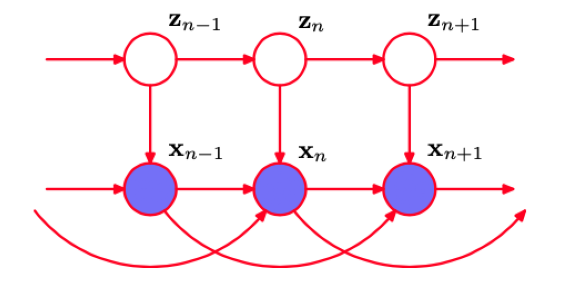

In [22]:
# 图13.17
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.17.png')
plt.axis('off')
ax.imshow(d)


图 13.17 自回归隐马尔可夫模型的一部分，其中，观测$ x_n $的概率分布依赖于之前的观测的子集以及隐状态$ z_n $。在这个例子中，$ x_n $的分布依赖于两个之前的观测$ x_{n−1} $和$ x_{n−2} $。

对于离散的观测来说，这对应于将发射概率分布的条件概率表进行扩展。在高斯发射概率密度的情形下，我们可以使用线性高斯的框架，其中，给定前一个观测的值以及$ z_n $的值的条件下，$ x_n $的条件概率分布是一个高斯分布，均值为条件变量值的一个线性组合。很明显，图中附加的链接必须被限制，避免自由参数的数量过多。在图13.17给出的例子中，每个观测依赖于前两个观测变量以及隐含状态。虽然这个图看起来很短，但是我们再次采用d-划分，可以看到，事实上，它有一 个简单的概率结构。特别的，如果我们假设以zn为条件，那么我们看到，与标准的HMM相同，$ z_{n−1} $和$ z_{n+1} $的值是独立的，对应于条件独立性质(13.5)。这很容易验证。我们注意到，每个从结点$ z_{n−1} $到结点$ z_{n+1} $的路径都要穿过至少一个关于那条路径头到尾连接的观测结点。从而，在EM算法的E步骤中，我们可以再次使用前向后向递归，确定潜在变量的后验概率分布，计算时间与链的长度是线性关系。类似地，M步骤值涉及到对标准的M步骤方程的一个微小的修改。在高斯发射密度的情形下，这涉及到使用第3章讨论的标准线性回归方程估计参数。

我们已经看到，当我们使用图模型时，自回归HMM可以看成标准HMM的一个很自然的扩展。事实上，概率图模型的观点会产生基于HMM的相当多种不同的图结构。另一个例子是输入 输出隐马尔科夫模型（input-output hidden Markov model）（Bengio and Frasconi，1995），其中我们有一个观测变量的序列$ u_1,...,u_N $，以及输出变量的序列$ x_1,...,x_N $，观测变量的值要么影响潜在变量的分布，要么影响输出变量的分布，或者对两者都产生影响。图13.18给出了一个例子。

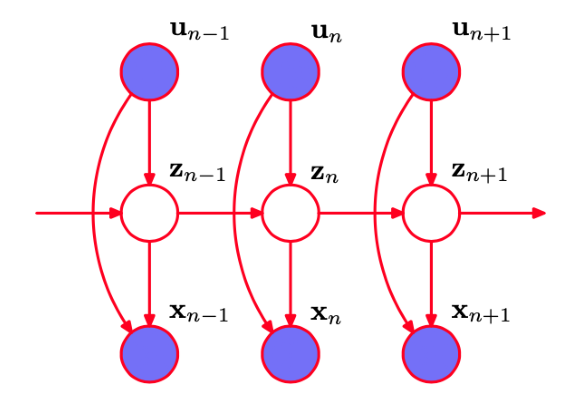

In [23]:
# 图13.18
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.18.png')
plt.axis('off')
ax.imshow(d)


 
图 13.18 输入输出隐马尔可夫模型的一个例子。在这种情况下，发射概率和转移概率都依赖于观测序列$ u_1,...,u_N $的值。

这将HMM的框架推广到了顺序数据的有监督学习领域。与之前一样，通过使用d-划分，很容易证明潜在变量链的马尔科夫性质(13.5)仍然成立。为了证明这一点，我们注意到从结点$ z_{n−1} $到结点$ z_{n+1} $只有一条路径，这条路径关于观测结点$ z_n $是头到尾的。这个条件独立性质又一次使得高效的学习算法的公式能够成立。特别的，我们可以通过最大化似然函数$ L(\theta) = p(X|U , \theta) $的方式确定模型参数$ \theta $，其中$ U $是一个矩阵，它的行等于$ u_n^T $。由于条件独立性质（13.5），可以使用EM算法对似然函数进行最大化，其中，E步骤涉及到前向和后向的递归。

HMM的另一个值得一提的变体是因子隐马尔可夫模型（factorial hidden Markov model）（Ghahramani and Jordan，1997），其中存在多个独立的潜在变量马尔科夫链，并且在一个给定的时刻，观测变量的概率分布以相同时间的所有对应的潜在变量的状态为条件。图13.19展示了对应的图模型。
 

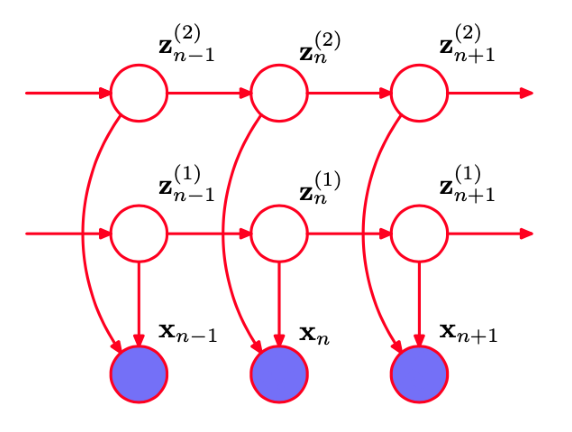

In [24]:
# 图13.19
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.19.png')
plt.axis('off')
ax.imshow(d)


图 13.19 由两个潜在变量马尔科夫链组成的因子马尔科夫模型。对于连续的观测变量$ x $，发射模型的一种可能的选择是线性高斯概率密度，其中高斯分布的均值是对应的潜在变量状态的线性组合。

为了说明研究因子HMM的动机，我们注意到，在一个给定的时刻，为了表示例如10比特的信息，标准的HMM需要$ K = 2^{10} = 1024 $个潜在状态，而因子HMM可以使用10个二值潜在链。然而，因子HMM的主要缺点是训练时的额外的复杂度。因子HMM的M步骤很容 易。然而，x变量的观测引入了潜在链之间的依赖关系，从而给E步骤带来了困难，说明如下。我们注意到在图13.19中，变量$ z_n^{(1)} $和$ z_n^{(2)} $由一个在结点$ x $处的头到头的路径链接，因此不是d-划分的。这个模型的精确的E步骤无法对应于在$ M $个马尔科夫链上独立地运行前向和后向递归。 我们注意到关键的条件独立性质（13.5）对于因子HMM模型中的各个马尔科夫链不成立，图13.20给出了使用d-划分的结果，从而证实了确实无法独立地运行前向和后向递归。
 

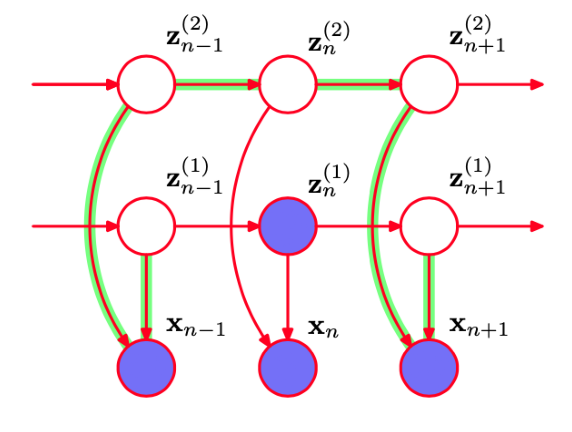

In [25]:
# 图13.20
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图13.20.png')
plt.axis('off')
ax.imshow(d)


图 13.20 绿色标记的路径在观测结点$ x_{n-1} $和$ x_{n+1} $处是头到头的，在非观测结点$ z_{n-1}^{(2)}, z_n^{(2)} $和$ z_{n+1}^{(2)} $处是头到尾的。因此路径没有被阻隔，从而条件独立性质（13.5）对于因子HMM模型的各个潜在链不成立。结果，这个模型没有高效的精确E步骤。

现在假设有$ M $个隐含结点链，并且为了简化起见，我们假设所有的潜在变量的状态数量都为$ K $。这样，在一个给定的时刻，一种方法会关注潜在变量的$ K^M $种组合，因此我们可以将模型转化为一个等价的标准HMM，它由一个单独的潜在变量链，每个潜在变量有$ K^M $个潜在状态。然后我们可以在E步骤中运行标准的前向后向递归方法。计算复杂度为$ O(NK^{2M}) $，它与潜在链的数量$ M $是指数的关系，因此除了对于很小的$ M $值以外均无法计算。一个解决方法是使用采样方法(第11章讨论)。作为另一个优雅的确定性的解决方法，Ghahramani and Jordan(1997)研究了使用变分推断方法来得到近似推断的一个可以计算的算法。可以这样做：使用一个简单的变分后验概率分布，它关于潜在变量可以完全分解，或者使用一个更强大的方法，其中变分分布由独立的马尔科夫链描述，马尔科夫链对应于原始模型中的潜在变量链。在后一种情形中，变分推断算法涉及到沿着每条链独立地运行前向和后向递归，这在计算上很有效率，同时也能够描述同一个链上的变量之间的相关性。

很明显，根据特定的应用需要，可以构建许多可能的概率模型。图模型提供了一个一般的方法来提出、描述、分析这些结果，变分方法提供了一个强大的框架，对无法得到精确解的模型进行推断。



# 13.3 线性动态系统

为了说明线性动态系统的概念，让我们考虑下面这个简单的例子，它经常在实际问题中出现。假设我们希望使用一个有噪声的传感器测量一个未知量$ z $的值，传感器返回一个观测值$ x $，表示$ z $的值加上一个0均值的高斯噪声。给定一个单次的测量，我们关于$ z $的最好的猜测是假设$ z = x $。然而，我们可以通过取多次测量然后求平均的方法提高我们对z的估计效果，因为随机噪声项倾向于彼此抵消。现在，让我们将情况变得更复杂。假设我们希望测量一个随着时间变化的量$ z $。我们可以对进行常规的测量$ x $，从而我们得到了$ x_1,...,x_n $，我们希望找到对应的$ z_1,...,z_n $。如果我们简单地对测量求平均，那么由于随机噪声产生的误差会被消去，但是不幸的是我们会仅仅得到一个单一的平均估计，对$ z $的变化进行了平均，从而引入了一种新的误差。

直观上讲，我们可以用下面的方式稍微好一些地完成这个任务。为了估计$ z_N $的值，我们只取最近的几次测量，例如$ x_{N−L},..., x_N $，然后求平均。如果$ z $的变化很慢，并且传感器的随机噪声的水平很高，那么选择一个相对长的窗又求平均是有意义的。相反，如果信号变化很快， 并且噪声水平相对较小，那么我们直接使用$ x_N $来估计$ z_n $会更合适。如果我们求加权平均，即最近的测量比之前的测量的贡献更大，那么或许效果会更好。
虽然这种主观的讨论似乎是可行的，但是它并没有告诉我们如何求加权平均，并且任何一种人工设计的权值都很难成为最优的。幸运的是，我们可以更加系统化地解决这种问题，方法是定义一个概率模型，它描述了时间的演化和测量过程，然后应用了之前章节中讨论的推断和学习方法。这里，我们关注一类广泛使用的模型，被称为线性动态系统（linear dynamical system）。

正如我们已经看到的，HMM对应于图13.5给出的状态空间模型，其中潜在变量是离散的，但是发射概率分布是任意的。这个图显然描述了相当大的一类概率分布，所有的都可以根据式（13.6）进行分解。我们现在考虑对潜在变量的其他类型的概率分布的推广。特别地，我们考虑连续潜在变量，其中加和-乘积算法的求和变成了积分。然而，推断算法的一般形式与隐马尔可夫模型相同。值得注意的很有趣的一点是，历史上，隐马尔可夫模型和线性动态系统是独立研究的。然而，一旦它们都用图模型进行表示，它们之间的深层关系就立刻变得明显了。

一个重要的要求是，我们保留了推断的高效算法，它与链的长度是线性关系。例如，这要求，在给定观测$ x_1,...,x_{n−1} $的条件下，表示$ z_{n−1} $的后验概率分布的量$ \hat{\alpha}(z_{n−1}) $在与转移概率$ p(z_n|z_{n−1}) $和发射概率$ p(x_n | z_n) $相乘然后在$ z_{n−1} $上求和或积分之后，我们得到的$ z_n $上的概率分布与$ \hat{\alpha}(z_{n−1}) $上的概率分布具有相同的函数形式。也就是说，在每个阶段，概率分布不可以变得更复杂，而是仅仅在参数值上发生改变。毫不令人惊讶地说，在多次相乘之后具有这个性质的唯一的分布就是指数族分布的成员。

这里，我们从实际应用的角度考虑一个最重要的例子，即高斯分布。特别地，我们考虑一个线性高斯状态空间模型，从而潜在变量$ {z_n} $以及观测变量$ {x_n} $是多元高斯分布，均值是图表示中的状态的线性函数。我们已经看到，线性高斯单元的有向图等价于所有变量上的联合高斯分布。此外，诸如$ \hat{\alpha}(z_n) $的边缘概率分布也是高斯分布，从而信息的函数形式被保留了下来，我们可以得到一个高效的推断算法。相反，假设发射概率密度$ p(x_n|z_n) $由$ K $个高斯分布混合而成， 每个高斯分布的均值都是$ z_n $的线性函数，那么即使$ \hat{\alpha}(z_1) $是一个高斯分布，$ \hat{\alpha}(z_2) $会是$ K $个高斯分布的混合，$ \hat{\alpha}(z_3) $会是$ K^2 $个高斯分布的混合，以此类推，因此精确的推断没有实际价值。

我们已经看到隐马尔科夫模型可以看成第9章的混合模型的一个推广，它允许数据之间具有顺序相关性。类似的，我们可以将线性动态系统看成第12章的连续潜在变量模型（如概率PCA和因子分析）的推广，每对结点$ {z_n, x_n} $表示那个特定的观测下的一个线性高斯潜在变量模型。然而，潜在变量$ {z_n} $不再被看成独立的，而是构成了一个马尔科夫链。

由于模型由树结构的有向图表示，因此推断问题可以使用加-乘算法高效地求解。前向递归方程，类似于隐马尔可夫模型的$ \alpha $信息，被称为Kalman滤波(Kalman filter)方程(Kalman， 1960; Zarchan and Musoff， 2005)，后向递归方程，类似于β信息，被称为Kalman平滑(Kalman smoother)方程，或者Rauch-Tung-Striebel (RTS)方程(Rauch et al.， 1965)。Kalman滤波被广泛应用于许多实时跟踪应用中。

由于线性动态系统是一个线性高斯模型，因此在所有变量上的联合概率分布以及边缘分布和条件分布都是高斯分布。它遵循下面的事实：单独地概率最大的潜在变量值组成的序列与概率最大的潜在变量序列相同。因此对于线性动态系统，无需考虑与维特比算法类似的算法。

由于模型的条件概率分布是高斯分布，因此我们可以将转移分布和发射分布写成一般的形式
$ \begin{eqnarray} p(z_n|z_{n-1} = \mathcal{N}(z_n|Az_{n-1},\Gamma) \tag{13.75} \\ p(x_n|z_n) = \mathcal{N}(x_n|Cz_n,\Sigma) \tag{13.76} \end{eqnarray} $
初始潜在变量也服从高斯分布，我们写成
$ p(z_1) = \mathcal{N}(z_1|\mu_0,P_0) \tag{13.77} $
注意，为了简化记号，我们省略了高斯分布的均值中额外的可加性常数。事实上，如果必要的话，加上这些常数是很容易的。传统上，这些概率分布通常使用噪声线性方程表示为一个等价的形式，噪声线性方程为
$ \begin{eqnarray} z_n = Az_{n-1} w_n \tag{13.78} \\ x_n = Cz_n + v_n \tag{13.79} \\ z_1 = \mu_0 + u \tag{13.80} \end{eqnarray} $
其中噪声项的概率分布为
$ \begin{eqnarray} w \sim \mathcal{N}(w|0, \Gamma) \tag{13.81} \\ v \sim \mathcal{N}(v|0, \Sigma) \tag{13.82} \\ u \sim \mathcal{N}(u|0, P_0) \tag{13.83} \end{eqnarray} $
模型的参数被记作$ \theta = {A, \Gamma, C, \Sigma, \mu_0, P_0} $，可以通过EM算法使用最大似然的方法确定。在E步骤中，我们需要求解确定潜在变量的局部后验边缘概率的推断问题，这可以使用加-乘算法高效地求出，我们将在下一节讨论。



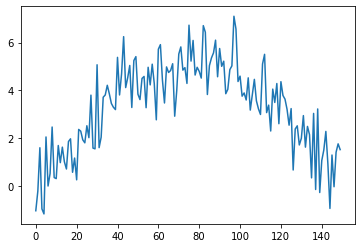

In [12]:
# plot
observed_sequence = np.concatenate(
    (np.arange(50)[:, None] * 0.1 + np.random.normal(size=(50, 1)),
     np.random.normal(loc=5., size=(50, 1)),
     5 - 0.1 * np.arange(50)[:, None] + np.random.normal(size=(50, 1))), axis=0)
plt.plot(observed_sequence)
plt.show()

In [13]:
# data
kalman = Kalman(
    system=np.array([[1., 1.], [0., 1.]]),
    cov_system=np.eye(2) * 0.001,
    measure=np.array([[1., 0.]]),
    cov_measure=np.eye(1) * 10,
    mu0=np.zeros(2), P0=np.eye(2) * 100
)

In [14]:
# para
mean, cov = kalman.filtering(observed_sequence)

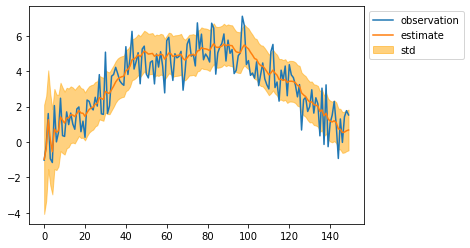

In [15]:
# plot
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

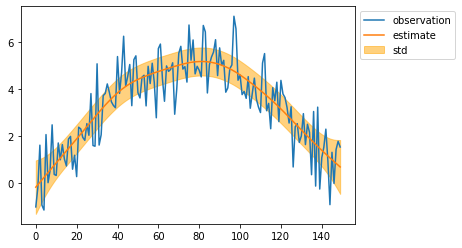

In [16]:
# plot
mean, cov = kalman.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

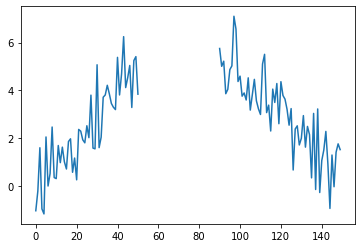

In [17]:
# draw
observed_sequence = [None if 50 < i < 90 else obs for i, obs in enumerate(observed_sequence)]
plt.plot(observed_sequence)
plt.show()

In [18]:
# data
kalman = Kalman(
    system=np.array([[1., 1.], [0., 1.]]),
    cov_system=np.eye(2) * 0.001,
    measure=np.array([[1., 0.]]),
    cov_measure=np.eye(1) * 10,
    mu0=np.zeros(2), P0=np.eye(2) * 100
)


In [19]:
# para
mean = []
std = []
for obs in observed_sequence:
    m, s = kalman.predict()
    if obs is not None:
        m, s = kalman.filter(obs)
    mean.append(m[0])
    std.append(np.sqrt(s[0, 0]))
mean = np.asarray(mean)
std = np.asarray(std)

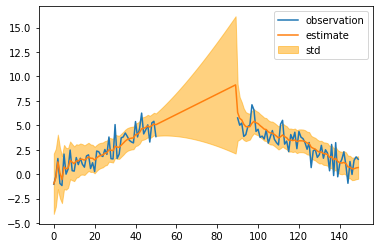

In [20]:
#plot
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

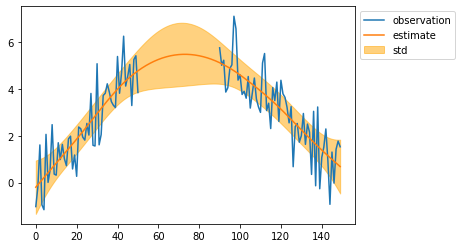

In [21]:
# plot
mean, cov = kalman.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## 13.3.1 LDS中的推断

我们现在考虑寻找以观测序列为条件的潜在变量的边缘概率分布的问题。在实时应用中，对于给定的参数设置，我们也希望以观测数据$ x_1,...,x_{n−1} $为条件，对于下一个潜在状态$ z_n $以及下一个观测$ x_n $做出预测。这些推断问题可以使用加-乘算法高效地解决，这个算法在线性动态系统的问题中会给出Kalman滤波方程和Kalman平滑方程。
值得强调的是，因为线性动态系统是线性高斯模型，因此所有潜在变量和观测变量上的联合概率分布是高斯分布，因此原则上我们可以使用之前章节推导的多元变量高斯分布的边缘概率 和条件概率的标准结果来解决这个推断问题。加-乘算法的作用是为这些计算提供了一个更加高效的方式。
线性动态系统与隐马尔可夫模型具有相同的分解方式，由公式(13.6)给出，并且由图13.14 和图13.15的因子图描述。于是，推断问题的形式完全相同，唯一的差别在于潜在变量上的求和被替换为积分。首先，我们考虑前向方程，其中我们将$ z_N $看做根结点，然后从叶结点$ h(z_1) $将信息传递到根结点。根据式（13.77），初始信息服从高斯分布，并且由于每个因子都服从高斯分布，因此所有后续的信息也都服从高斯分布。按照传统，我们传递的信息是标准化的边缘概率分布，对应于$ p(z_n|x_1,...,x_n) $，我们将其记作
$ \hat{\alpha}(z_n) = \mathcal{N}(z_n|\mu_n,V_n) \tag{13.84} $
这与式（13.59）给出的隐马尔科夫模型的离散变量情形的缩放变量$ \hat{\alpha}(z_n) $的传播完全相同，因此递归方程的形式为
$ c_n\hat{\alpha}(z_n) = p(x_n|z_n)\int\hat{\alpha}(z_{n−1})p(z_n|z_{n−1})dz_{n−1} \tag{13.85} $
使用式（13.75）和（13.76）替换$ p(z_n|z_{n−1}) $和$ p(x_n|z_n) $，然后使用式（13.84），我们看到（13.85）变成了
$ \begin{eqnarray} c_n\mathcal{N}(z_n|\mu_n,V_n) = \mathcal{N}(x_n|Cz_n,\Sigma) \ \int\mathcal{N}(z_n|Az_{n-1},\Gamma)\mathcal{N}(z_{n-1}|\mu_{n-1},V_{n-1})dz_{n-1} \tag{13.86} \end{eqnarray} $
这里我们假设$ \mu_{n−1} $和$ V_{n−1} $是已知的，并且通过计算式（13.86）中的积分，我们希望确定$ \mu_n $和$ V_n $的值。使用式（2.115）给出的结果，这个积分很容易计算。我们有
$ \begin{eqnarray} \int\mathcal{N}(z_n|Az_{n-1},\Gamma)\mathcal{N}(z_{n-1}|\mu_{n-1},V_{n-1})dz_{n-1} \ = \mathcal{N}(z_n|A\mu_{n-1},P_{n-1}) \tag{13.87} \end{eqnarray} $
其中我们定义了
$ P_{n-1} = AV_{n-1}A^T + \Gamma \tag{13.88} $
我们现在可以将这个结果与式（13.86）右侧的第一个因子结合，使用式（2.115）和（2.116），有
$ \begin{eqnarray} \mu_n &=& Aμn−1 + Kn(xn − CAμn−1) \tag{13.89} \ V_n &=& (I − K_nC)P_{n−1} \tag{13.90} \ c_n &=& \mathcal{N}(x_n |CA\mu_{n−1}, CP_{n−1}C^T + \Sigma) \tag{13.91} \end{eqnarray} $
这里，我们使用了矩阵求逆的恒等式（C.5）和（C.7），并且定义了Kalman增益矩阵(Kalman gain matrix)
$ K_n = P_{n-1}C^T(CP_{n-1}C^T + \Sigma)^{-1} \tag{13.92} $
因此，给定$ \mu_{n−1} $和$ V_{n−1} $，以及新的观测$ x_n $，我们可以计算$ z_n $的高斯边缘分布，均值为$ \mu_n $，协方差为$ V_n $，标准化系数为$ c_n $。
这些递归方程的初始条件为
$ c_1\hat{\alpha}(z_1) = p(z_1)p(x_1|z_1) \tag{13.93} $
由于$ p(z_1) $由式（13.77）给出，$ p(x_1|z_1) $由式（13.76）给出，因此我们可以再次使用（2.115）计算$ c_1 $，使用（2.116）计算$ \mu_1 $和$ V_1 $，结果为
$ \begin{eqnarray} \mu_1 &=& \mu_0 + K_1(x_1 - C\mu_0 \tag{13.94} \ V_1 &=& (I - K_1C)P_0 \tag{13.95} \ c_1 &=& \mathcal{N}(x_1|C\mu_0,CP_0C^T + \Sigma) \tag{13.96} \end{eqnarray} $
其中
$ K_1 = P_0C^T(CP_0C^T + \Sigma)^{-1} \tag{13.97} $
类似的，线性动态系统的似然函数由式（13.63）给出，其中因子$ c_n $使用Kalman滤波方程求解。
我们可以直观地给出从$ z_{n−1} $上的后验边缘分布到$ z_n $上的后验边缘分布的步骤，如下所述。在式（13.89）中，我们可以将$ A\mu_{n−1} $看成$ z_n $上的均值的预测，得到这个预测的方法是在$ z_{n−1} $上取均值，然后使用一个前向的步骤，使用转移概率矩阵$ A $进行投影。预测均值会给出$ x_n $的一个预测观测$ CA\mu_{n−1} $，得到这个预测的方法是讲发射概率矩阵$ C $作用在预测的隐含状态均值上。我们可以将隐含变量分布的均值的更新方程（13.89）看成将预测分布的均值$ A\mu_{n−1} $加上一个修正项，这个修正项正比于预测观测与实际观测之间的误差$ x_n − CA\mu_{n−1} $。 这个修正的系数由Kalman增益矩阵给出。因此我们可以将Kalman滤波的过程看成下面的过程：首先做出后续的预测，然后使用新的观测来修正这些预测。图13.21给出了图形说明。
 
图 13.21 线性动态系统可以被看成一个步骤序列，其中由于传播造成的状态变量的逐渐增大的不确定性由新数据的到达所补偿。在左图中，蓝色曲线表示概率分布$ p(z_{n−1}|x_1,...,x_{n−1}) $，它整合了截止到第$ n − 1 $步的所有的数据。由方差非零的转移概率$ p(z_n|z_{n−1}) $产生的传播过程给出了概率分布$ p(z_n|x_1,...,x_{n−1}) $，在中间图中表示为红色曲线。注意，与蓝色曲线相比，红色曲线更宽，并且有所偏移。为了对比，蓝色曲线用虚线画出。下一个数据观测$ x_n $通过发射概率密度$ p(x_n|z_n) $产生贡献。右图中的绿色曲线表示发射概率与$ z_n $的函数关系。注意，它不是关于$ z_n $的概率密度，因此没有被归标准化。使用这个新的数据点会产生状态概率密度的一个修正的概率分布$ p(z_n |x_1,...,x_n) $,用蓝色表示。我们看到，与$ p(z_n|x_1,...,x_{n−1}) $相比，数据的观测使得概率分布产生偏移，并且变得更窄了。为了对比，$ p(z_n |x_1,...,x_{n−1}) $在右图中用红色虚线表示。
如果我们考虑下面的情形：与潜在变量的变化速率相比，测量误差相对较小，那么我们看到zn的后验概率分布仅仅依赖于当前的测量xn，这与我们在本节开始时的简单例子中获得的直观感受相符。类似地，如果与观测的噪声水平相比，潜在变量的变化速度较慢，那么我们发 现zn的后验均值等于对截止到那个时间的所有测量求平均。
Kalman滤波的一个重要应用是跟踪。图13.22使用一个物体在二维空间移动的简单例子说明了这一点。
 
图 13.22 线性动态系统用于移动物体跟踪的一个说明。蓝点表示在连续的时刻，二维空间中物体的真实位置，绿点表示带有噪声的对位置的测量，红色叉号表示使用Kalman滤波方程推断出的后验概率分布的均值。推断位置的协方差由红色椭圆表示，它对应于一个标准差的轮廓线。
目前位置，我们已经解决了在给定$ x_1 $到$ x_n $的观测的情况下寻找结点zn的后验边缘概率的问题。接下来，我们考虑在给定$ x_1 $到$ x_N $的所有观测的条件下，寻找结点$ z_n $的边缘概率的问题。对于时序数据，这对应于将未来的观测以及过去的观测全部包含在内。虽然这无法用于实时预测，但是它在学习模型的参数中起着重要的作用。通过与隐马尔科夫模型的类比，这个问题可以这样求解：从结点$ x_N $将信息反向传递到结点$ x_1 $，然后将这个信息与计算$ \hat{\alpha}(z_n) $的前向信息传递阶段得到的信息相结合。
在LDS的文献中，通常根据$ \gamma(z_n) = \hat{\alpha}(z_n)\hat{\beta}(z_n) $表示后向递归公式，而是不根据$ \hat{\beta}(z_n) $。由于$ \gamma(z_n) $一定也是高斯分布，因此我们有
$ \gamma(z_n)=\hat{\alpha}(z_n)\hat{\beta}(z_n) = \mathcal{N}(z_n|\hat{\mu}_n, \hat{V}_n) \tag{13.98} $
为了推导所求的递归方程，我们从$ \hat{\beta}(z_n) $的反向递归方程（13.62）开始，它对于连续潜在变量，可以写成
$ c_{n+1}\hat{\beta}(z_n) = \int\hat{\beta}(z_{n+1})p(x_{n+1}|z_{n+1})p(z_{n+1}|z_n)dz_{n+1} \tag{13.99} $
我们现在将（13.99）两侧乘以$ \hat{\alpha}(z_n) $，使用式（13.75）和（13.76）消去$ p(x_{n+1}|z_{n+1}) $和$ p(z_{n+1}|z_n) $。然后，我们使用（13.89）、（13.90）和（13.91），以及（13.98），经过一些计算，我们有
$ \begin{eqnarray} \hat{\mu}n &=& \mu_n + J_n(\hat{\mu}{n+1} + A\mu_n) \tag{13.100} \ \hat{V}n &=& V_n + J_n\left(\hat{V}{n+1} - P_n\right)J_n^T \tag{13.101} \ &=& \frac{\mathcal{N}(z_{n-1}|\mu_{n-1},V_{n-1})\mathcal{N}(z_n|Az_{n-1},\Gamma)\mathcal{N}(x_n|Cz_n,\Sigma)\mathcal{N}(z_n|\hat{\mu}_n,\hat{V}_n)}{c_n\hat{\alpha}(z_n)} \tag{13.103} \end{eqnarray} $
其中我们定义了
$ J_n = V_nA^T(P_n)^{-1} \tag{13.102} $
并且我们使用了$ AV_n =P_nJ_n^T $。注意，这些递归方程要求首先完成前向传递的过程，从而在后向过程中可以使用$ \mu_n $和$ V_n $。
对于EM算法，我们也需要求出一对变量的后验边缘分布，它可以通过公式(13.65)求出， 形式为
$ \begin{eqnarray} \xi(z_{n-1},z_n) &=& (c_n)^{-1}\hat{\alpha}(z_{n-1})p(x_n|z_n)p(z_n|z_{n-1})\hat{\beta}(z_n) \ \end{eqnarray} $
使用式（13.84）消去$ \hat{\alpha}(z_n) $，整理，我们看到$ \xi(z_{n−1}, z_n) $是一个高斯分布，均值为$ [\hat{\mu}_{n−1},\hat{\mu}n]^T $，$ z_n $和$ z{n−1} $之间的协方差为
$ cov[z_{n-1},z_n] = J_{n-1}\hat{V}_n \tag{13.104} $



## 13.3.2 LDS中的学习

目前为止，我们已经研究了线性动态系统中的推断问题，假设模型的参数$ \theta = {A,\Gamma,C,\Sigma,\mu_0,P_0} $已知。接下来，我们考虑使用最大似然方法确定这些参数Ghahramani and Hinton，1996b）。由于模型具有潜在变量，因此可以使用第9章讨论的一般形式的EM算法来解决这个问题。
我们可以按照下面的方法推导线性动态系统的EM算法。让我们将算法在某个特定循环上的模型参数估计值记作$ \theta^{old} $。对于这些参数，我们可以运行推断算法来确定潜在变量的后验概率分布$ p(Z|X,\theta^{old}) $，或者更精确地确定那些在M步骤中所需的局部后验边缘概率。特别的，我们需要下面的期望
$ \begin{eqnarray} \mathbb{E}[z_m] &=& \hat{\mu}n \tag{13.105} \ \mathbb{E}[z_nz{n-1}^T] &=& \hat{V}nJ{n-1}^T + \hat{\mu}n\hat{\mu}{n-1}^T \tag{13.106} \ \mathbb{E}[z_nz_n^T] &=& \hat{V}_n + \hat{\mu}_n\hat{mu}_n^T \tag{13.107} \end{eqnarray} $
其中我们已经使用了公式（13.104）。
现在我们考虑完整数据对数似然函数，它通过对式（13.6）取对数的方式得到，因此结果为
$ \begin{eqnarray} \ln p(X,Z|\theta) &=& \ln p(z_1|\mu_0,P_0) + \sum\limits_{n=2}^N\ln p(z_n|z_{n-1},A,\Gamma) \ & & + \sum\limits_{n=1}^N\ln p(x_n|z_n,C,\Sigma) \tag{13.108} \end{eqnarray} $
其中我们显式地写出了对参数的依赖关系。我们现在对完整数据对数似然函数关于后验概率分布$ p(Z|X,\theta^{old}) $取期望，它定义了函数
$ Q(\theta,\theta^{old}) = \mathbb{E}_{Z|\theta^{old}}[\ln p(X,Z|\theta)] \tag{13.109} $
在M步骤中，函数关于$ \theta $的分量进行最大化。
首先考虑参数$ \mu_0 $和$ P_0 $。如果我们使用（13.77）消去式（13.108）中的$ p(z_1|\mu_0, P_0) $，然后关于$ Z $取期望，得到
$ Q(\theta,\theta^{old}) = -\frac{1}{2}\ln |P_0| - \mathbb{E}_{Z|\theta^{old}}\left[\frac{1}{2}(z_1 - \mu_0)^TP_0^{-1}(z_1 - \mu_0)\right] + const $
其中所有不依赖于$ \mu_0 $或$ P_0 $的项都被整合到了可加性常数中。使用2.3.4节讨论的高斯分布的最大似然解，关于$ \mu_0 $和$ P_0 $进行最大化很容易进行，结果为
$ \begin{eqnarray} \mu_0^{new} &=& \mathbb{E}[z_1] \tag{13.110} \ V_0^{new} &=& \mathbb{E}[z_1z_1^T] - \mathbb{E}[z_1]\mathbb{E}[z_1^T] \tag{13.111} \end{eqnarray} $
类似的，为了最优化$ A $和$ \Gamma $，我们使用式（13.75）消去（13.108）中的$ p(z_n|z_{n−1}, A, \Gamma) $，结果为
$ \begin{eqnarray} Q(\theta,\theta^{old}) = &-&\frac{N-1}{2}\ln |\Gamma| \ &-& \mathbb{E}{Z|\theta^{old}}\left[\frac{1}{2}\sum\limits{n=2}^N(z_n - Az_{n-1})^T\Gamma^{-1}(z_n - Az_{n-1})\right] + const \tag{13.112} \end{eqnarray} $
其中常数项由不依赖与$ A $和$ \Gamma $的项组成。关于这些参数最大化可得
$ \begin{eqnarray} A^{new} &=& \left(\sum\limits_{n=2}^N\mathbb{E}[z_nz_{n-1}^T]\right)\left(\sum\limits_{n=2}^N\mathbb{E}[z_{n-1}z_{n-1}^T]\right)^{-1} \tag{13.113} \ \Gamma^{new} &=& \frac{1}{N-1}\sum\limits_{n=2}^N\Bigg{\mathbb{E}[z_nz-n^T] - A^{new}\mathbb{E}[z_{n-1}z_n^T] \ & & -\mathbb{E}z_nz_{n-1}^T^T + A^{new}\mathbb{E}z_{n-1}z_{n-1}^T^T\Bigg} \tag{13.114} \end{eqnarray} $
注意，$ A^{new} $必须首先计算，然后用它的结果来确定$ \Gamma^{new} $。
最后，为了确定$ C $和$ \Sigma $的新值，我们使用式（13.76）消去式（13.108）中的$ p(x_n|z_n,C,\Sigma) $，可得
$ \begin{eqnarray} Q(\theta,\theta^{old}) = &-& \frac{N}{2}\ln |\Sigma| \ &-&\mathbb{E}{Z|\theta^{old}}\left[\frac{1}{2}\sum\limits{n=1}^N(x_n - Cz_n)^T\Sigma^{-1}(x_n - Cz_n)\right] + const \end{eqnarray} $
关于$ C $和$ \Sigma $最大化，可得
$ \begin{eqnarray} C^{new} &=& \left(\sum\limits_{n=1}^Nx_n\mathbb{E}[z_n^T]\right)\left(\sum\limits_{n=1}^N\mathbb{E}[z_nz_n^T]\right)^{-1} \tag{13.115} \ \Sigma^{new} &=& \frac{1}{N}\sum\limits_{n=1}^N{x_nx_n^T - C^{new}\mathbb{E}[z_n]x_n^T \ & & -x_n\mathbb{E}z_n^T^T + C^{new}\mathbb{E}z_nz_n^T^T} \tag{13.116} \end{eqnarray} $
我们得到了使用最大似然方法学习线性动态系统的参数的方法。引入先验概率分布得到MAP估计的方法很简单。使用第10章讨论的近似方法，可以得到一个完整的贝叶斯方法。篇幅所限，不在这里详细介绍这些内容。



## 13.3.3 LDS的推广

与隐马尔科夫模型相同，为了增强模型的能力，我们对推广基本的线性动态系统有着浓厚的兴趣。虽然线性高斯模型的假设会产生高效的推断和学习算法，但是它也暗示了观测变量的边缘概率分布是一个高斯分布，这会产生很大的局限性。线性动态系统的一个简单的推广是使用 高斯混合分布作为初始分布$ z_1 $。如果这个混合分布有$ K $个分量，那么前向递归方程（13.85）会 产生隐含变量$ z_n $上的$ K $个高斯分布的混合分布，因此模型是可以计算的。
对于许多应用来说，高斯发射概率密度是一个很差的近似。如果我们尝试使用$ K $个高斯分布的混合分布作为发射概率密度，那么后验概率分布$ \hat{\alpha}(z_1) $也会是$ K $个高斯分布的混合。然而，根据式（13.85），后验概率分布$ \hat{\alpha}(z_2) $由$ K^2 $个高斯分布混合而成，以此类推，$ \hat{\alpha}(z_n) $由$ K^n $个高斯分布混合而成。因此，分量的数量随着链的长度指数增长，因此模型无法计算。
更一般地，引入与线性高斯（或指数族）分布差距较大的转移模型或者发射模型会产生一个无法计算的推断问题。我们可以进行确定性的近似，例如假设的密度过滤或者期望传播，或 者我们可以使用13.3.4节讨论的采样方法。一个广泛使用的方法是在预测分布的均值附近进行线性化从而进行了高斯近似，这就产生了推广的Kalman滤波（extended Kalman filter）（Zarchan and Musoff， 2005）。
与隐马尔可夫模型相同，我们可以通过扩展图表示的方法来对基本的线性动态系统进行有趣的推广。例如，切换状态空间模型（switching state space model）（Ghahramani and Hinton，1998）可以被看成隐马尔科夫模型与一组线性动态系统的的组合。模型有多个由连续线性高斯潜在变量组成的马尔科夫链，每一个都类似于之前讨论的线性动态系统的潜在链。模型中还包含了一个在隐马尔科夫模型中使用的离散变量形式的马尔科夫链。在每个时刻的输出按照下面的方式确定：随机选择一个一个连续潜在链，使用离散潜在变量作为一个开关，然后从对应的条件输出分布发射一个观测。这个模型中精确的推断是无法进行的，但是变分方法会产生出一个高效的推断方法，涉及到沿着每个连续的和离散的马尔科夫链独立进行的前向和后向算法。注意，如果我们考虑离散潜在变量的多个链，然后使用一个作为开关，从剩余的链中选择，那么我们得到了一个只有离散潜在变量的类似的模型，被称为切换隐马尔科夫模型（switching hidden Markov model）。



## 13.3.4 粒子滤波

对于没有线性高斯分布的动态系统，例如使用非高斯发射概率密度的动态系统，为了得到一个可以计算的推断算法，我们使用采样算法。特别地，我们可以使用11.1.5节讨论的采样-重要性-在采样方法，得到一个顺序的蒙特卡罗算法，被称为粒子滤波。
考虑图13.5中的图模型表示的概率分布，假设我们有观测变量$ X_n =(x_1,...,x_n) $，我们希望从后验概率分布$ p(z_n|X_n) $中抽取$ L $个样本。使用贝叶斯定理，我们有
$ \begin{eqnarray} \mathbb{E}[f(z_n)] &=& \int f(z_n)p(z_n|X_n)dz_n \ &=& \int f(z_n)p(z_n|x_n,X_{n-1})dz_n \ &=& \frac{\int f(z_n)p(x_n|z_n)p(z_n|X_{n-1})dz_n}{\int p(x_n|z_n)p(z_n|X_{n-1})dz_n} \ &\simeq& \sum\limits_{l=1}^Lw_n^{(l)}f(z_n^{(l)}) \tag{13.117} \end{eqnarray} $
其中$ {z_n^{(l)}} $是从$ p(z_n|X_n) $中抽取的一组样本，并且我们使用了条件独立性质$ p(x_n|z_n,X_{n-1}) = p(x_n|z_n) $，这个性质来自于图13.5所示的图模型。采样权值$ {w_n^{(l)}} $的定义 为
$ w_n^{(l)} = \frac{p(x_n|z_n^{(l)})}{\sum\limits_{m=1}^Lp(x_n|z_n^{(m)})} \tag{13.118} $
其中我们在分子和分母中使用了同样的样本。因此后验概率分布$ p(z_n|X_n) $由样本集合$ {z_n^{(l)}} $以及对应的权值$ {w_n^{(l)}} $表示。注意，权值一定满足$ 0 \leq w_n^{(l)} \leq 1 $以及$ \sum_l w_n^{(l)} = 1 $。
由于我们希望找到一个顺序采样的方法，因此我们假设我们在时刻$ n $已经得到了一组样本和权值，并且我们顺序地观测到了$ x_{n+1} $的值，我们希望找到时刻$ n + 1 $的权值和样本。我们首先从概率分布$ p(z_{n+1}|X_n) $中采样。这很容易做到，因为使用贝叶斯定义，我们有
$ \begin{eqnarray} p(z_{n+1}|X_n) &=& \int p(z_{n+1}|z_n, X_n)p(z_n|X_n)dz_n \ &=& \int p(z_{n+1}|z_n)p(z_n|X_n)dz_n \ &=& \int p(z_{n+1}|z_n)p(z_n|x_n, X_{n−1})dz_n \ &=& \frac{\int p(z_{n+1}|z_n)p(x_n|z_n)p(z_n|X_{n−1})dz_n}{p(x_n|z_n)p(z_n|X_{n−1})dz_n} \ &\simeq& \sum\limits_lw_n^{(l)}p(z_{n+1}|z_n^{(l)}) \tag{13.119} \end{eqnarray} $
其中我们使用了条件独立性质
$ \begin{eqnarray} p(z_{n+1}|z_n, X_n) &=& p(z_{n+1}|z_n) \tag{13.120} \ p(x_n|z_n, X_{n−1}) &=& p(x_n|z_n) \tag{13.121} \end{eqnarray} $
这可以通过对图13.5所示的图模型应用d-划分准则的方式得到。式(13.119)的概率分布是一个混合分布，样本可以通过下面的方式得到：根据混合系数$ w^{(l)} $指定的概率，选择一个分量$ l $， 然后从对应的分布中采样。
总结一下，我们可以将粒子滤波算法的每一步看成由两个阶段组成。在时刻$ n $，我们有一个后验概率$ p(z_n|X_n) $的样本表示，它根据$ {z_n^{(l)}} $以及对应的权值$ {w_n^{(l)}} $表示。这可以看成形如（13.119）的混合表示。为了得到下一个时刻的对应的表示，我们首先从混合分布（13.119）中抽取$ L $个样本，然后对于每个样本，我们使用新的观测$ x_{n+1} $计算对应的权值$ w_{n+1}^{(l)} \propto p(x_{n+1}|z_{n+1}^{(l)}) $。图13.23说明了单一变量$ z $的情形。
 
图 13.22 对于一维潜在空间，粒子滤波操作的图形表示。在时刻$ n $，后验概率分布$ p(z_n|x_n) $被表示为混合概率分布，用圆圈表示，它的大小正比于权值$ w_n^{(l)} $。之后，一组$ L $个样本从这个概率分布中抽取，新的权值$ w_{n+1}^{(l)} $使用$ p(x_{n+1}| z_{n+1}^{(l)}) $计算。
粒子滤波或者顺序蒙特卡罗方法在文献中有多个名字，包括自助滤波（bootstrap filter） （Gordon et al.， 1993）、最适幸存（survival of the fittest）（kanazawa et al.， 1995）以及凝结算法 （condensation algorithm）（Isard and Blake， 1998）。



In [22]:
# data
observed_sequence = np.concatenate(
    (np.arange(50)[:, None] * 0.1 + np.random.normal(size=(50, 1)),
     np.random.normal(loc=5., size=(50, 1)),
     5 - 0.1 * np.arange(50)[:, None] + np.random.normal(size=(50, 1))), axis=0)

In [23]:
# fun
def nll(observed, particle):
    diff = observed - particle @ np.array([1., 0.])
    return 0.1 * (diff ** 2)

particle = Particle(np.random.normal(0, 1, (1000, 2)), system=np.array([[1, 1], [0, 1]]), cov_system=np.eye(2) * 0.001, nll=nll)

In [24]:
# para
mean, cov = particle.filtering(observed_sequence)
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])

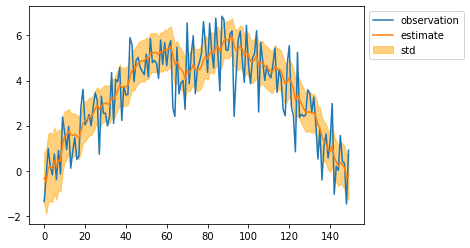

In [25]:
# plot
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

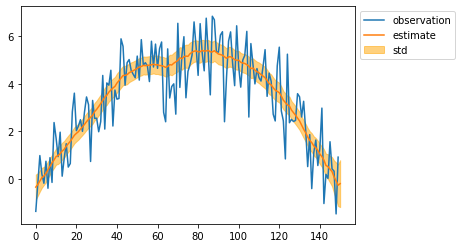

In [26]:
# plot
mean, cov = particle.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [28]:
observed_sequence = [None if 50 < i < 90 else obs for i, obs in enumerate(observed_sequence)]

In [29]:
# model
particle = Particle(np.random.normal(0, 1, (1000, 2)), system=np.array([[1, 1], [0, 1]]), cov_system=np.eye(2) * 0.001, nll=nll)
mean = []
std = []
for obs in observed_sequence:
    p, w = particle.predict()
    if obs is not None:
        p, w = particle.filter(obs)
    mean.append(np.average(p, axis=0, weights=w)[0])
    std.append(np.cov(p, rowvar=False, aweights=w)[0, 0])
mean = np.asarray(mean)
std = np.asarray(std)

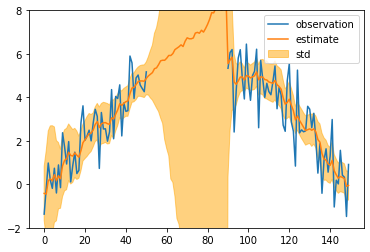

In [30]:
# plot
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.ylim(-2, 8)
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

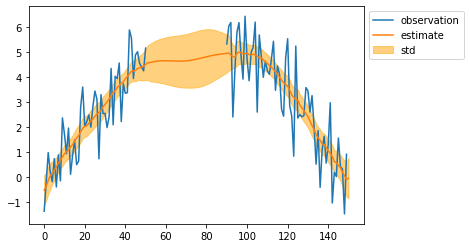

In [31]:
# plot
mean, cov = particle.smoothing()
mean = mean[:, 0]
std = np.sqrt(cov[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(mean, label="estimate")
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()